<a href="https://colab.research.google.com/github/y1m1ng1in/Site-Traffic-Prediction/blob/main/traffic_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Team Newbee: Week 9 Traffic Prediction 

In order to make a prediction based on previous traffic data, the following section analysis the traffic from Nov. 4th 00:00:58 to Nov. 18th 00:00:58 (GMT). 

## Existing Traffic Analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


First we take all 14 access logs downloaded from instance-1, process the data we need and create an "access.csv" for future analysis.


In [ ]:
import csv
import re

logfiles = [ 'access.log.{n}'.format(n=i) for i in range(14,0,-1) ] + [ 'access.log' ]

print(logfiles)

prog = re.compile(r"""
    (
        \d{1,3}.
        \d{1,3}.
        \d{1,3}.
        \d{1,3}      # group[1] ipv4
    )
    \s-\s-\s
    \[
        (\d{1,2})/   # group[2] date
        (\w{3})/     # group[3] month
        (\d{4}):     # group[4] year
        (\d{2}):     # group[5] hour
        (\d{2}):     # group[6] minute
        (\d{2})      # group[7] second
        \s\+0000
    \]
    \s
    "
        (\w+)        # group[8] http_method
        \s  
        ([^\s]*)     # group[9] path
        \s
        ([^\s]*)     # group[10] http version
    "
    \s
    (\d{3})          # group[11] status code
    \s
    (\d+)            # group[12] body bytes sent
    \s
    (.*)             # group[13] referer and agent
                     # need group[] request time
                     # need group[] ...
""" , re.X)

with open('access.csv', 'w', newline='') as csvfile, open('cannot_recognize.txt','w') as errorfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['upstream_addr','day','month','year','hour','minute',
                         'second','http_method','path','http_version','status_code',
                         'body_bytes_sent','referer and agent'])
    for logfile in logfiles:
        with open(logfile, 'r') as logfile:
            for line in logfile:
                result = prog.match(line)
                if result == None:
                    errorfile.write(line)
                else:
                    csv_writer.writerow([result.group(1),
                                         result.group(2),
                                         result.group(3),
                                         result.group(4),
                                         result.group(5),
                                         result.group(6),
                                         result.group(7),
                                         result.group(8),
                                         result.group(9),
                                         result.group(10),
                                         result.group(11),
                                         result.group(12),
                                         result.group(13)])
            logfile.close()
        
    csvfile.close()
    errorfile.close()

['access.log.14', 'access.log.13', 'access.log.12', 'access.log.11', 'access.log.10', 'access.log.9', 'access.log.8', 'access.log.7', 'access.log.6', 'access.log.5', 'access.log.4', 'access.log.3', 'access.log.2', 'access.log.1', 'access.log']


In [ ]:
import pandas as pd

def conv(str_month):
    months = { 'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7,
               'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12 }
    try:
        int_month = months[str_month]
    except KeyError:
        int_month = -1
    return int_month

df = pd.read_csv('access.csv', converters={'month':conv})

In [ ]:
df['year'] = pd.to_numeric(df['year'])


df['timestamp'] = pd.to_datetime({'year'  : df['year'],
                                  'month' : df['month'],
                                  'day'   : df['day'],
                                  'minute': df['minute'],
                                  'hour'  : df['hour'],
                                  'second': df['second']})

df = df.set_index('timestamp')

In [ ]:
df.dtypes

upstream_addr        object
day                   int64
month                 int64
year                  int64
hour                  int64
minute                int64
second                int64
http_method          object
path                 object
http_version         object
status_code           int64
body_bytes_sent       int64
referer and agent    object
dtype: object

In [ ]:
df.head(3)

,upstream_addr,day,month,year,hour,minute,second,http_method,path,http_version,status_code,body_bytes_sent,referer and agent
timestamp,,,,,,,,,,,,,
2020-11-04 00:00:58,97.115.172.126,4,11,2020,0,0,58,GET,/about/,HTTP/1.1,200,690,"""-"" ""python-requests/2.19.1"""
2020-11-04 00:02:03,97.115.172.126,4,11,2020,0,2,3,GET,/home,HTTP/1.1,301,0,"""-"" ""python-requests/2.19.1"""
2020-11-04 00:02:03,97.115.172.126,4,11,2020,0,2,3,GET,/home/,HTTP/1.1,200,936,"""-"" ""python-requests/2.19.1"""


In [ ]:
def aggregrate(freq, dataframe=df):
    start, end = df.index[0], df.index[-1]
    rng = pd.date_range(start, end, freq=freq, closed='left')
    dataset = [dataframe.loc[rng[i]:rng[i + 1]] for i in range(0, len(rng) - 1)]
    counting_df = pd.DataFrame(zip([rng[i] for i in range(0, len(rng) - 1)],
                                   [rng[i] for i in range(1, len(rng))],
                                   [len(d) for d in dataset]), 
                               columns=['interval_start', 'interval_end', 'request_num'])
    return dataset, counting_df

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_by_freq(freq, df=df, title=None,xlabel=None):
    dataset, count_df = aggregrate(freq, dataframe=df)
    sns.set(rc={'figure.figsize':(20, 5)})
    ax = count_df['request_num'].plot(linewidth=0.5, marker='.', linestyle='-')
    ax.set_ylabel('Number of requests', fontsize=14)
    if title:
        ax.set_title(title, fontsize=20)
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=14)
    return dataset, count_df

### The Overall Traffic in 14-day period from Nov. 14th 00:00:58

The following figure plots the traffic from Nov. 4th 00:00:58 to Nov. 18th 00:00:58 (GMT) in a **hourly-counting** manner and **daily-counting** manner. Solely based on the two figures below, it can't tell too much. Thus, it is worthwile decomposing it based on client's ip addresses; aggregrated, explosive 404 error code; and so on. 

The rest of this section will analysis it by decomposing the whole data into traffic distribution from top1, top2, top3, top4 IPs, and rest of the clients. Also, we noticed that some clients use scrpit to automatically "explore" our site, which incurred significant amount of 404 error, thus those part of data are extracted from original data and treated as a individual distribution. 

Our prediction plans to employ a so called "Decomposition based on predictability" technique, since some of our components are deterministic (such as team member's doing assignment, Bruce and David "visit" our site by writing script, uptime bot's checking), the others non-deterministic components (the client all over the world who write script to explore our site). Thus, before make the prediction understand the data is important. 

For most of our models, the **x-axis** represents for number of hours elapsed from Nov-04 00:00:58. The **y-axis** represents for number of requests.

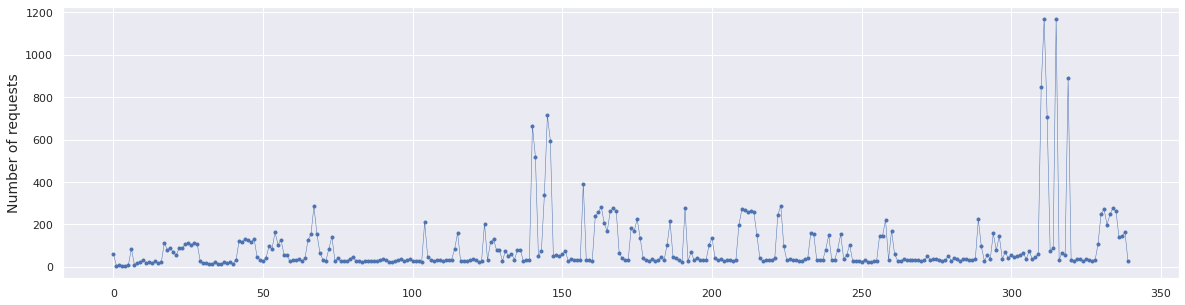

In [ ]:
dataset_hour, count_df_hour = plot_by_freq('1H')

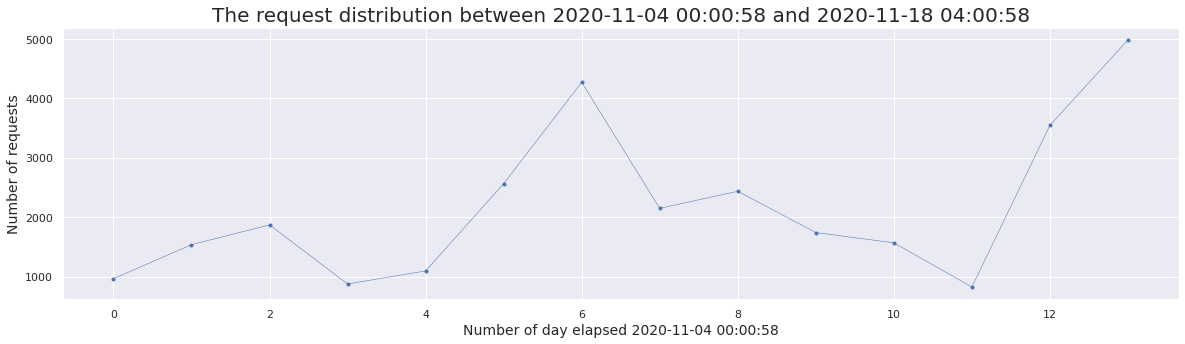

In [ ]:
dataset_day, count_df_day = plot_by_freq(
    '1D', 
    title="The request distribution between {s} and {e}".format(s=count_df_hour.iloc[0]['interval_start'],
                                                                e=count_df_hour.iloc[-1]['interval_end']),
    xlabel="Number of day elapsed {s}".format(s=count_df_hour.iloc[0]['interval_start']))

In [ ]:
class Analysis:
    
    def __init__(self, freq, dataframe=df):
        self.freq = freq
        self.dataset, self.count_df = aggregrate(freq, dataframe=dataframe)
        self.n_dataset = len(self.dataset)
        
    def __subplot_format(self, n_cols, figsize):
        if self.n_dataset == 1:
            return None
        n_cols = n_cols
        n_rows = int(self.n_dataset / n_cols)
        fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize, sharex=True)
        plt.subplots_adjust(right=2,top=2.5)
        return (fig, axes)
         
    def __plot_helper(self, top_n, df, subplot, index, n_cols, single_figsize):
        if not subplot:
            ax = df[:top_n].plot.barh(figsize=single_figsize)
        else:
            axes = subplot[1]
            ax = df[:top_n].plot.barh(ax=axes[int(index/n_cols), index%n_cols])
            axes[int(index/n_cols), index%n_cols].set_title(
                "{index} * {f} after {start}".format(index=index, f=self.freq, start=self.dataset[0].index[0]))
        ax.set_xlabel("number of requests")
    
    def plot_top_n(self, n=20, figsize=(10,14), single_figsize=(10,10), n_cols=2):
        subplot = self.__subplot_format(n_cols, figsize)
        for i, d in enumerate(self.dataset):
            count_clients = (d[['upstream_addr','http_method','path','status_code']]
                                .groupby(['upstream_addr'])
                                .size()
                                .sort_values(ascending=False)
                                .to_frame(name="count"))
            self.__plot_helper(n, count_clients, subplot, i, n_cols, single_figsize)
    
    def atry(self):
        print(self.dataset[0].index[0])

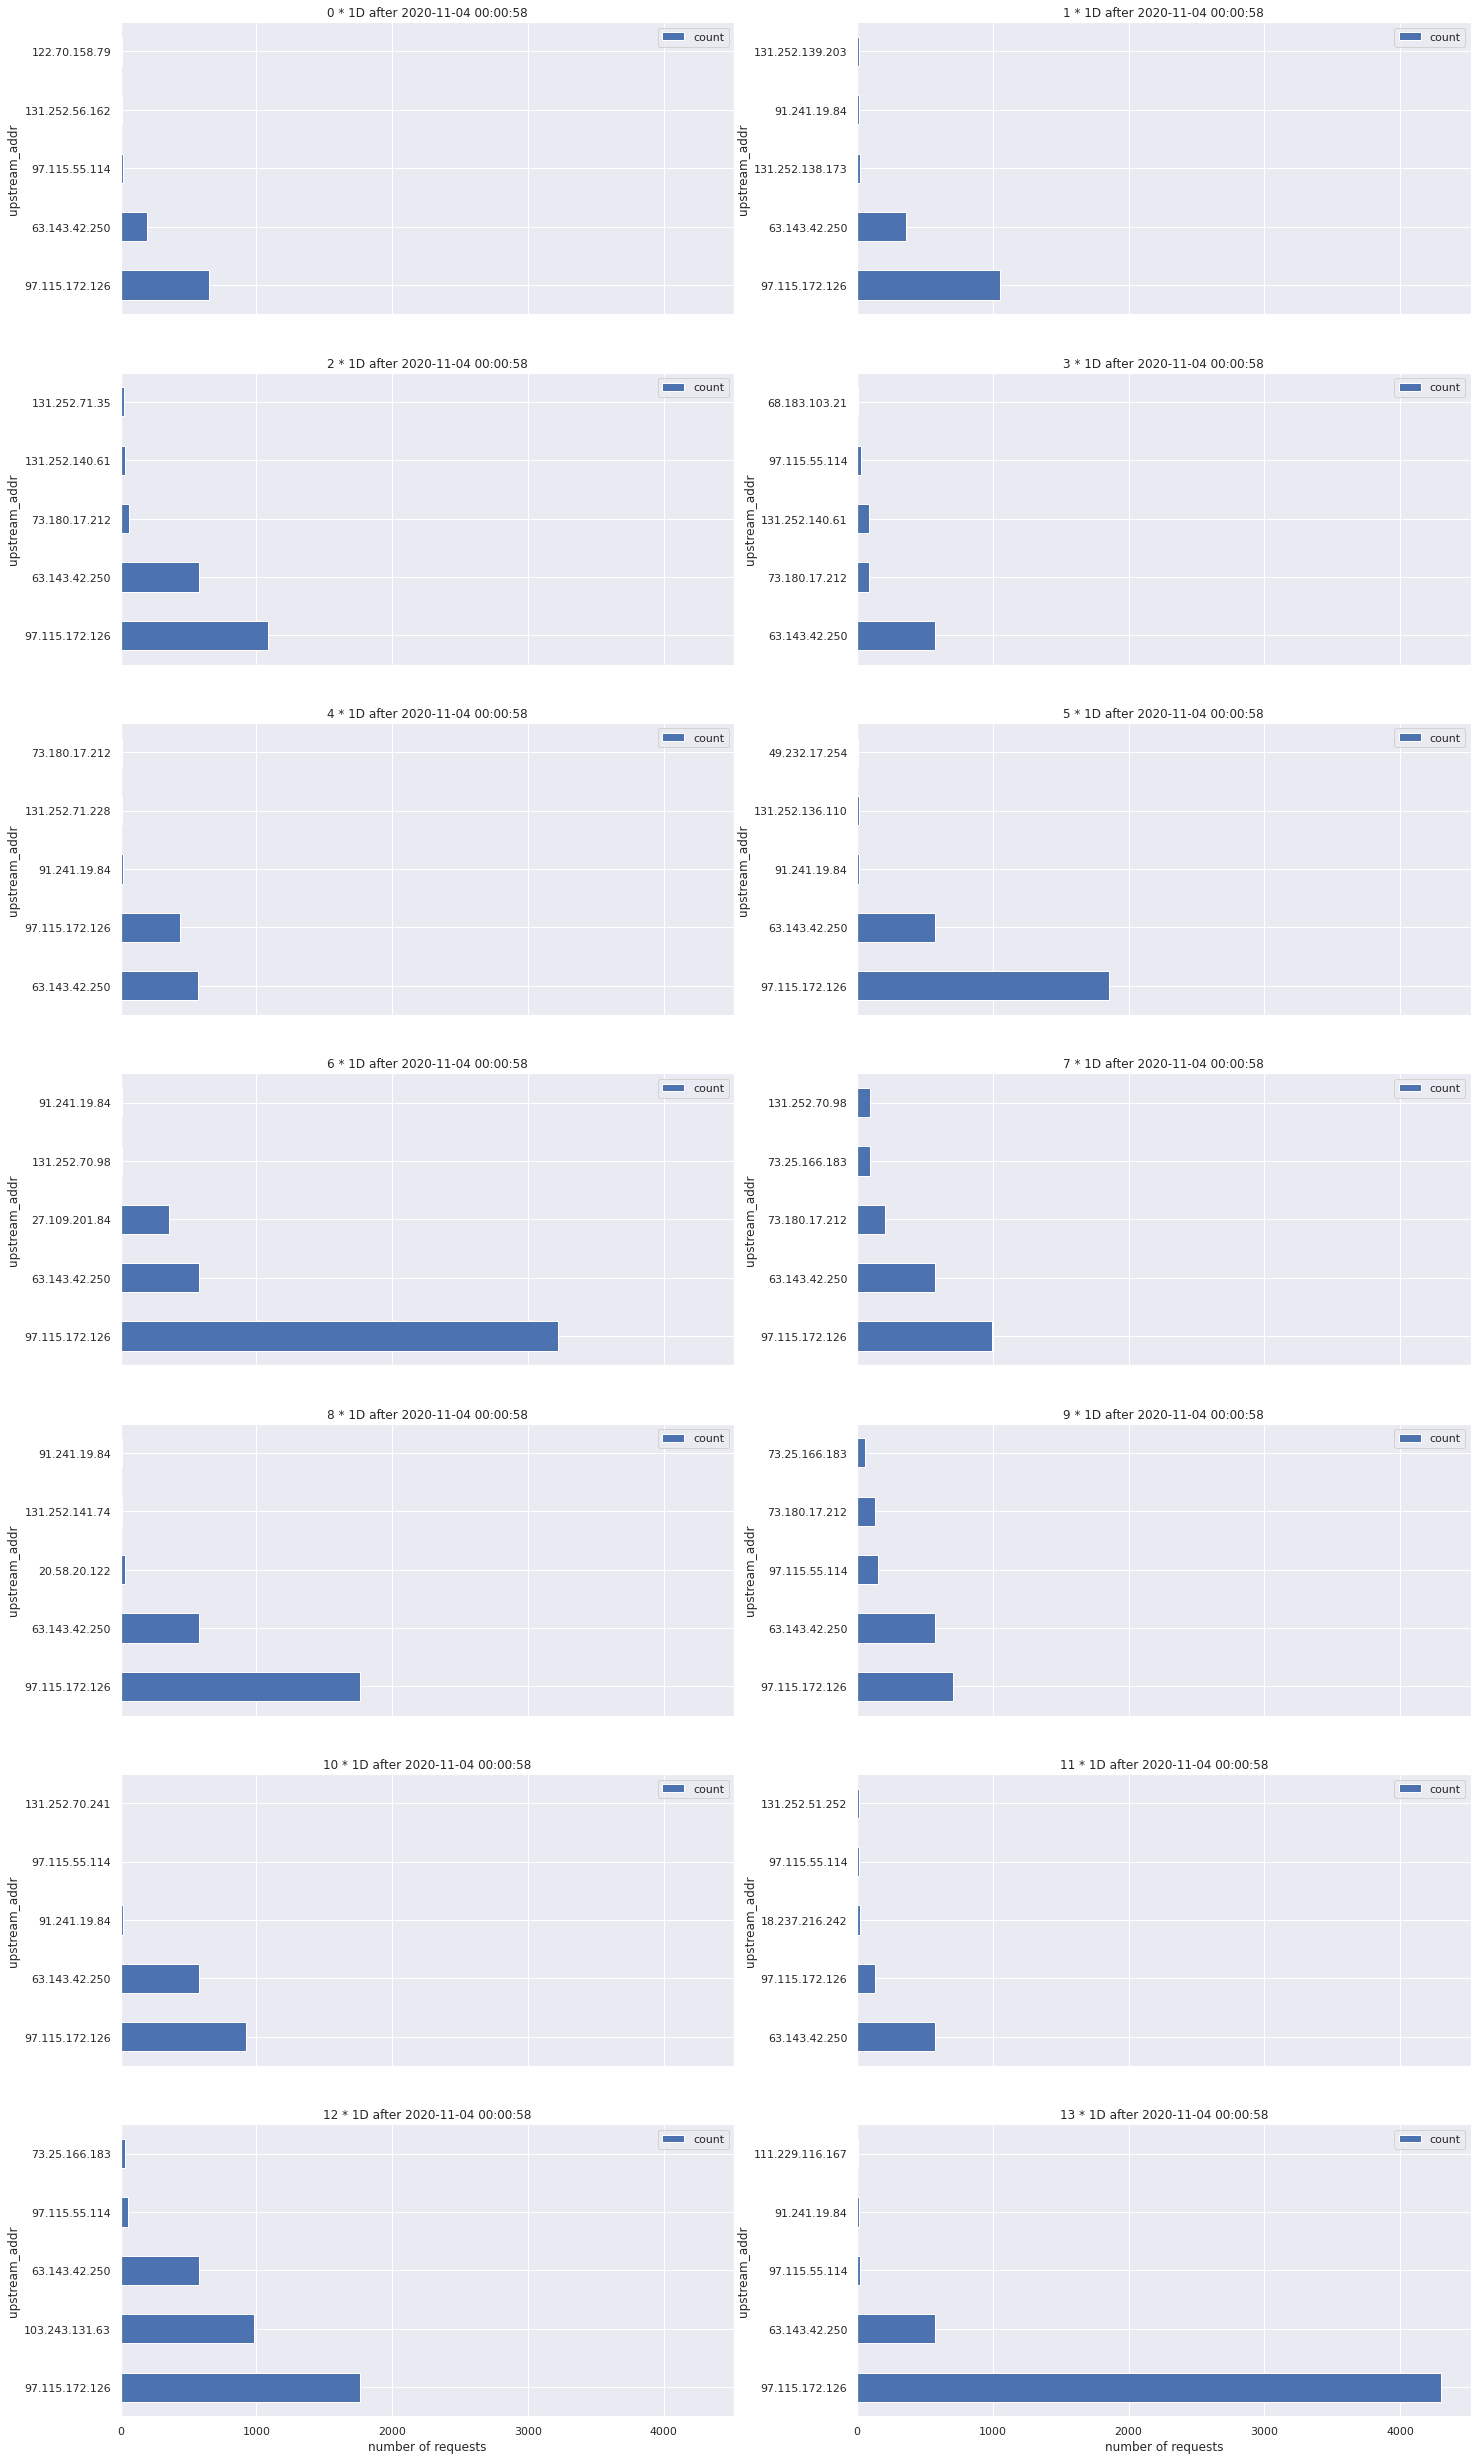

In [ ]:
d14 = Analysis('1D')
d14.plot_top_n(5)

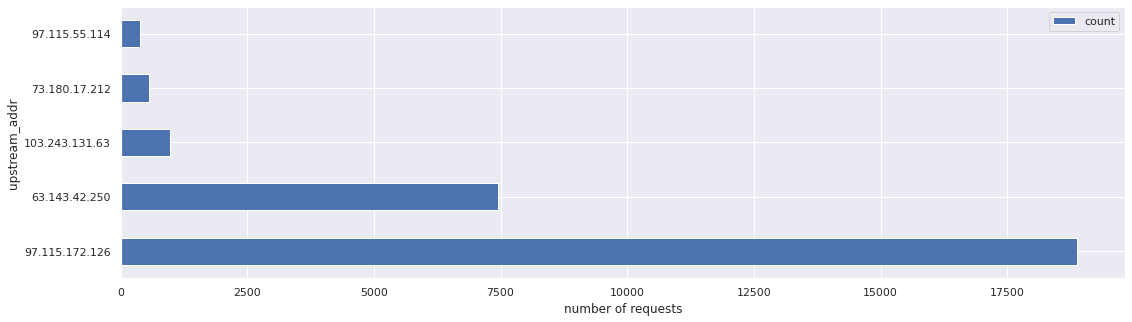

In [ ]:
d1 = Analysis('14D')
d1.plot_top_n(5, single_figsize=(18,5), n_cols=1)

In [ ]:
class IpAddrAnalysis:
    
    def __init__(self, freq, ip):
        self.freq = freq
        self.ip = ip
        self.ip_df = df.loc[df['upstream_addr'] == self.ip]
    
    def plot_count_by_ip(self):
        return plot_by_freq(self.freq, 
                            df=self.ip_df, 
                            title="The request distribution of {ip}".format(ip=self.ip),
                            xlabel="Number of hour elapsed {s}".format(s=count_df_hour.iloc[0]['interval_start']))
        

### The Distribution of 1st Traffic Contributor (Bruce)

If we look at the raw data, most of the requests from the http agent **"python-requests/2.19.1"** with IP **"97.115.172.126"**. We infer that this comes from Bruce's script. This distribution will be treated as a individual distribution which will be modelled and predict independently, as we make an assumption that event Bruce and David visit our site (by writting script) is independent with the event that clients in the rest of the world visit our site.

,interval_start,interval_end,request_num
0,2020-11-04 00:00:58,2020-11-04 01:00:58,59
1,2020-11-04 01:00:58,2020-11-04 02:00:58,2
2,2020-11-04 02:00:58,2020-11-04 03:00:58,3
3,2020-11-04 03:00:58,2020-11-04 04:00:58,3
4,2020-11-04 04:00:58,2020-11-04 05:00:58,1
...,...,...,...
335,2020-11-17 23:00:58,2020-11-18 00:00:58,240
336,2020-11-18 00:00:58,2020-11-18 01:00:58,104
337,2020-11-18 01:00:58,2020-11-18 02:00:58,91
338,2020-11-18 02:00:58,2020-11-18 03:00:58,138


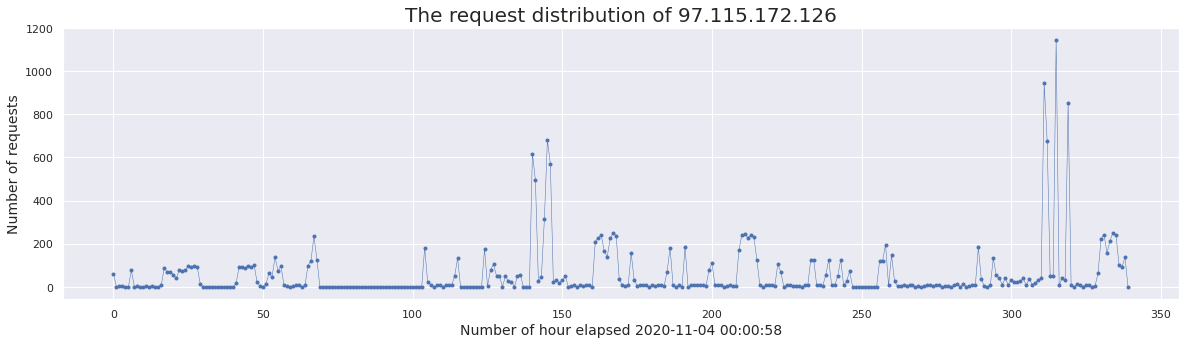

In [ ]:
ip_most = IpAddrAnalysis("1H", "97.115.172.126")    
ip_most_dataset, ip_most_count = ip_most.plot_count_by_ip()
ip_most_count

### The Distribution of 2st Traffic Contributor -- Uptime Bot
We also set up an uptimebot service that visits our site every 5 minutes just to inform us if our server is down.

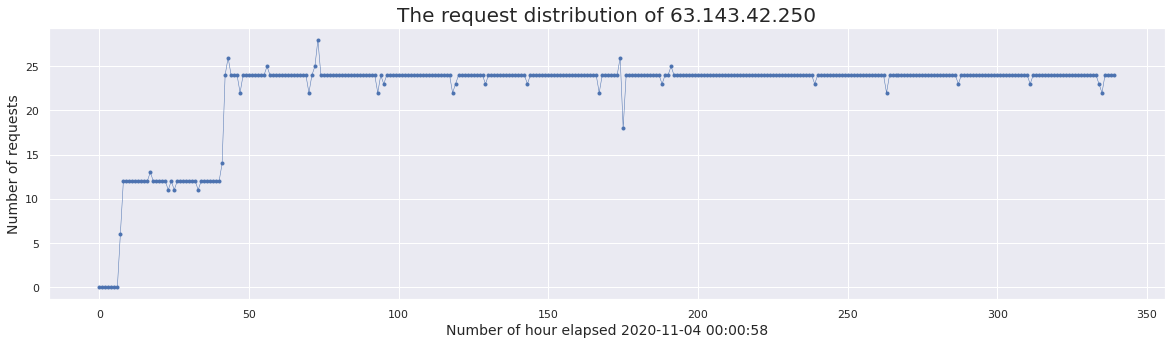

In [ ]:
ip_second = IpAddrAnalysis("1H", "63.143.42.250")    
ip_second_dataset, ip_second_count = ip_second.plot_count_by_ip()

### the Distribution of 3rd Traffic Contributor

The pattern of the distribution below appears more than at least once in our traffic. All of the requests they sent result in a 404 error (verified in the next code block).

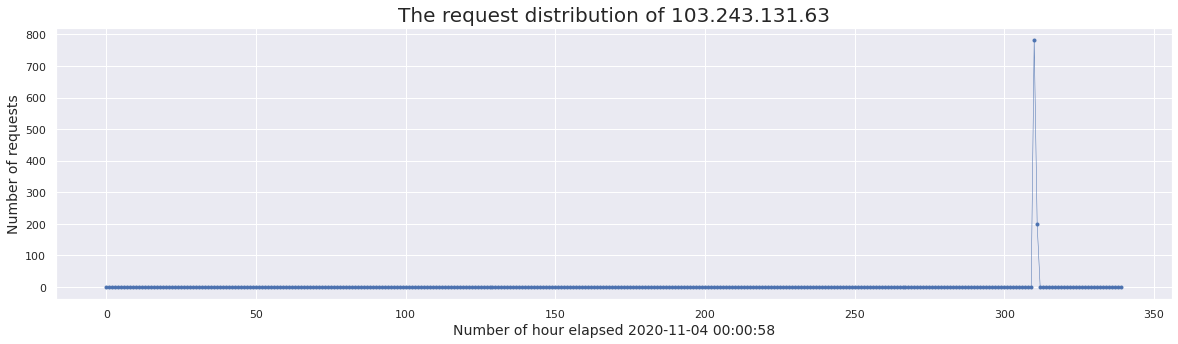

In [ ]:
ip_third = IpAddrAnalysis("1H", "103.243.131.63")    
ip_third_dataset, ip_third_count = ip_third.plot_count_by_ip()

The following verifies that "All of the requests they sent result in a 404 error".

In [ ]:
len(ip_third.ip_df) == len(ip_third.ip_df[ip_third.ip_df['status_code'] == 404])

True

### The Distribution of 4th Traffic Contributor

This client is kind of interesting, it nearly not makes requests with 404 response. Also, it is hardly to identify "who it is" as the case of top 1 and top 2. Thus, let's put it aside and will come back in the section of "Exploring the unknown fourth top traffic source -- 73.180.17.212"

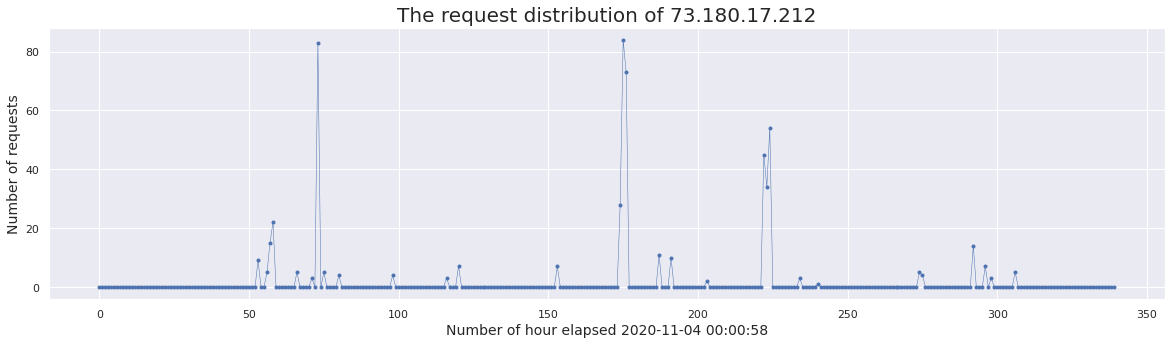

In [ ]:
ip_4th = IpAddrAnalysis("1H", "73.180.17.212")    
ip_4th_dataset, ip_4th_count = ip_4th.plot_count_by_ip()

In [ ]:
def assemble_ip_counts_with_overall(overall_df, ip_dfs):
    assembled = overall_df['request_num'].to_frame()
    for d, ip in ip_dfs:
        assembled = assembled.join(d['request_num'].to_frame().rename(columns={'request_num': ip}))
    sns.set(rc={'figure.figsize':(20, 15)})
    ax = assembled.plot(linewidth=0.5, marker='o', linestyle='-', color=sns.color_palette("magma_r"))
    return assembled, ax

Now we compare the top 4 traffic contributors with all the requests we got.

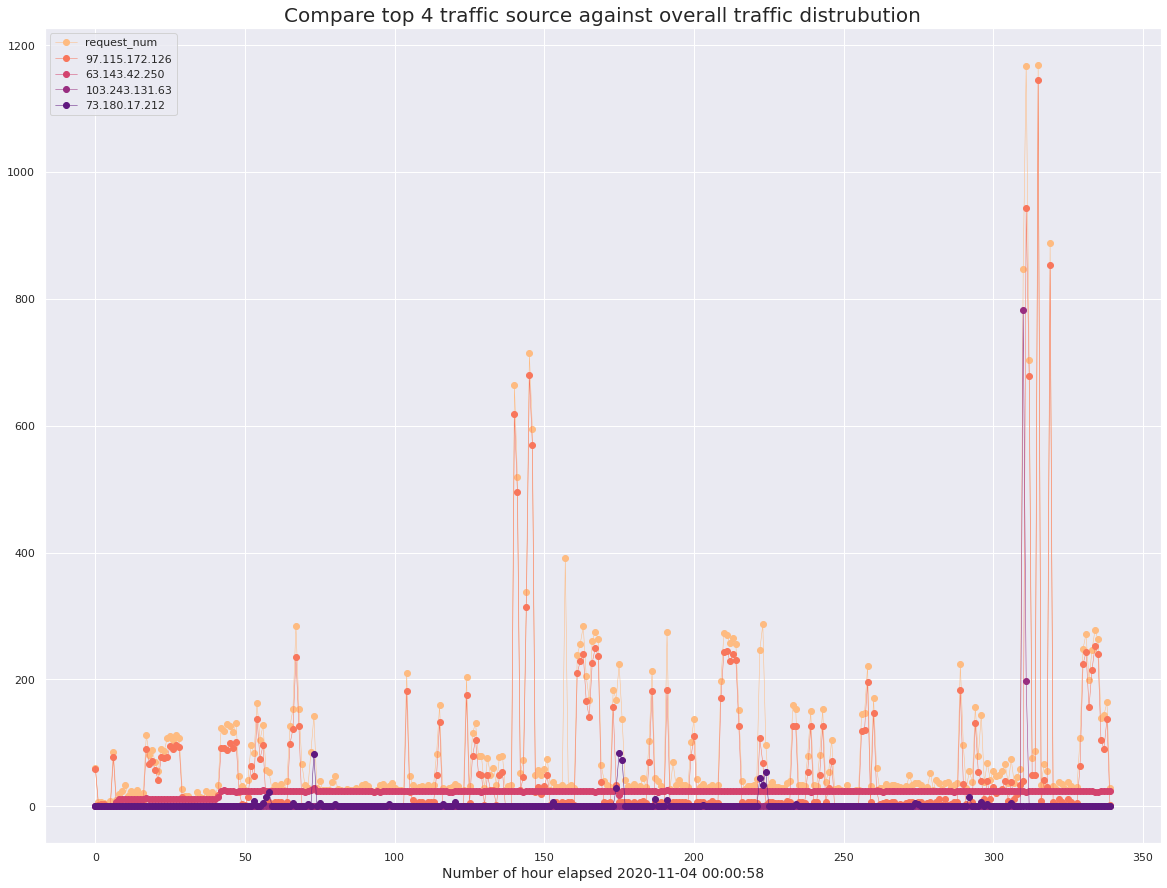

In [ ]:
assembled_top4, ax = assemble_ip_counts_with_overall(count_df_hour, 
                                                 [(ip_most_count, "97.115.172.126"),
                                                  (ip_second_count, "63.143.42.250"),
                                                  (ip_third_count, "103.243.131.63"),
                                                  (ip_4th_count, "73.180.17.212")])
title = ax.set_title("Compare top 4 traffic source against overall traffic distrubution", fontsize=20)
xlabel = ax.set_xlabel("Number of hour elapsed {s}".format(s=count_df_hour.iloc[0]['interval_start']), fontsize=14)

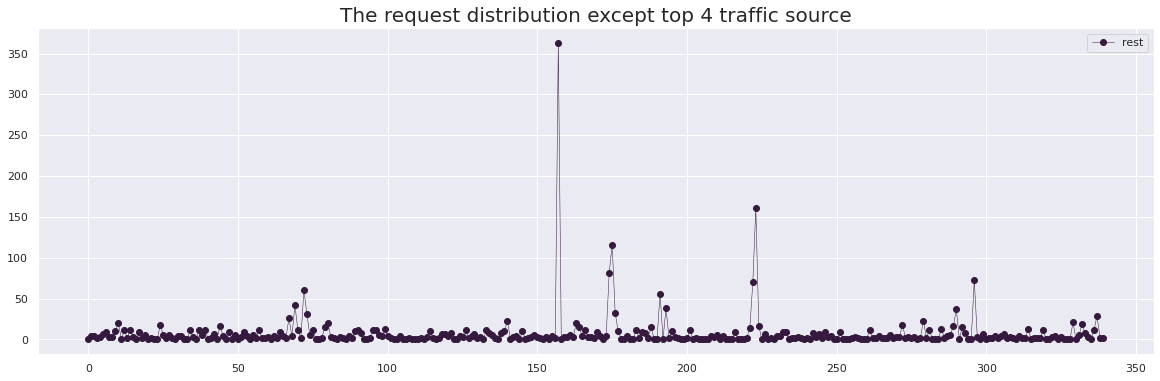

In [ ]:
assembled_top4['rest'] = (assembled_top4['request_num'] 
                        - assembled_top4['97.115.172.126']  # Bruce and David's testing script
                        - assembled_top4['63.143.42.250']   # uptime bot
                        - assembled_top4['103.243.131.63']  # 1-hour's explosive 404 error by someone's script
                        - assembled_top4['73.180.17.212'])  # 4th most requests during Nov.4 - Nov.18

sns.set(rc={'figure.figsize':(20, 6)})
ax = assembled_top4[['rest']].plot(linewidth=0.5, marker='o', linestyle='-', color=sns.color_palette("rocket"))
title = ax.set_title("The request distribution except top 4 traffic source", fontsize=20)

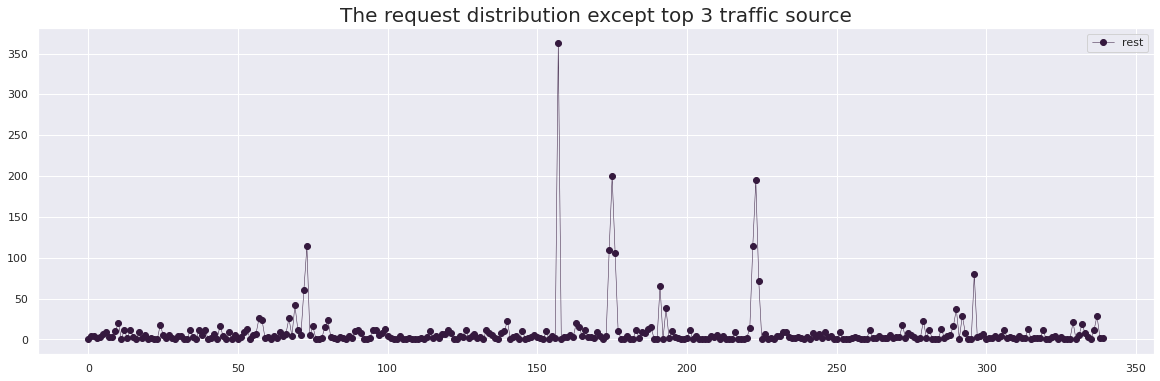

In [ ]:
assembled_top4['rest'] = (assembled_top4['request_num'] 
                        - assembled_top4['97.115.172.126']  # Bruce and David's testing script
                        - assembled_top4['63.143.42.250']   # uptime bot
                        - assembled_top4['103.243.131.63']) # 1-hour's explosive 404 error by someone's script

sns.set(rc={'figure.figsize':(20, 6)})
ax = assembled_top4[['rest']].plot(linewidth=0.5, marker='o', linestyle='-', color=sns.color_palette("rocket"))
title = ax.set_title("The request distribution except top 3 traffic source", fontsize=20)

### The Analysis of Requests with a 404 Reponse
Then we found requests with 404 responses should be taken as an independent distributor because each client using script to automatically explore our site tends to only explore once in a long period. The following figure shows a typical client's request distribution. The 3rd top traffic contributor also follows such a pattern. Also, we can make an assumption that the events that those clients explore our site are independent. So, these distribution can be grouped together (as joint pmf can be expressed as multiplication of all the marginal pmf).


True

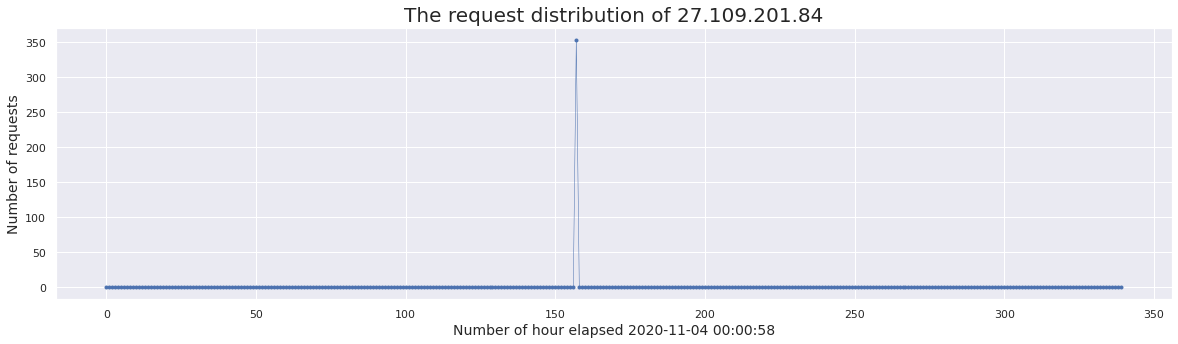

In [ ]:
# check the peak value above
ip_test_27_109_201_84 = IpAddrAnalysis("1H", "27.109.201.84") 
ip_27_109_201_84_dataset, ip_27_109_201_84_count = ip_test_27_109_201_84.plot_count_by_ip()
len(ip_test_27_109_201_84.ip_df) == len(
    ip_test_27_109_201_84.ip_df[ip_test_27_109_201_84.ip_df['status_code'] == 404])

In [ ]:
df_404 = df[df['status_code'] == 404]
dataset_404, counting_df_404 = aggregrate('1H', df_404)

Text(0.5, 1.0, 'Zoom in: Distribution of number of 404 requests')

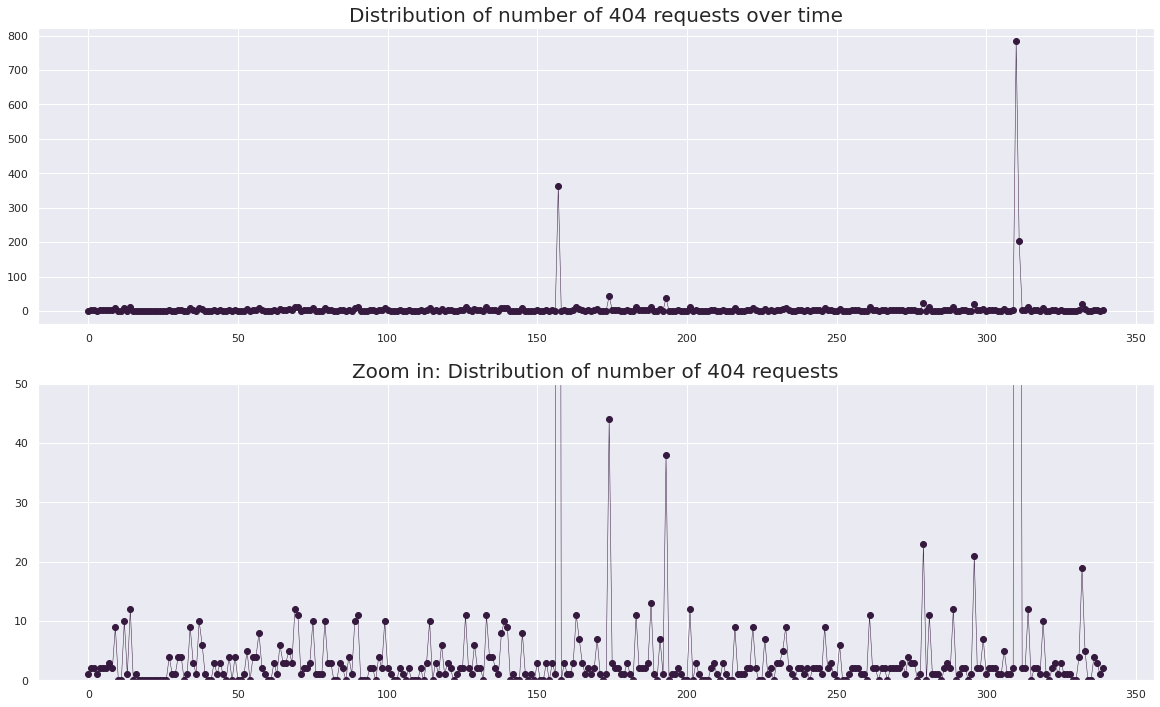

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1)
# sns.set(rc={'figure.figsize':(20, 12)})
ax = counting_df_404['request_num'].plot(
    ax=axes[0], linewidth=0.5, marker='o', linestyle='-', color=sns.color_palette("rocket"), figsize=(20,12))
axes[0].set_title('Distribution of number of 404 requests over time', fontsize=20)
ax = counting_df_404['request_num'].plot(
    ax=axes[1], linewidth=0.5, marker='o', linestyle='-', color=sns.color_palette("rocket"), figsize=(20,12))
plt.ylim(0,50)
axes[1].set_title('Zoom in: Distribution of number of 404 requests', fontsize=20)

### The Distribution without Top4 Source Traffic and 404 Requests

We are also interested in the distribution that contains all the traffic that does not result in a 404 error code, also does not involve top4 traffic sources. The following section analysis such a distribution (call it "distribution K"). 

Firstly, we plot the traffic in a hourly counting manner and a daily counting manner as the following.

Text(0.5, 1.0, 'Distribution K: daily traffic without Top4 Source Traffic and 404 Requests')

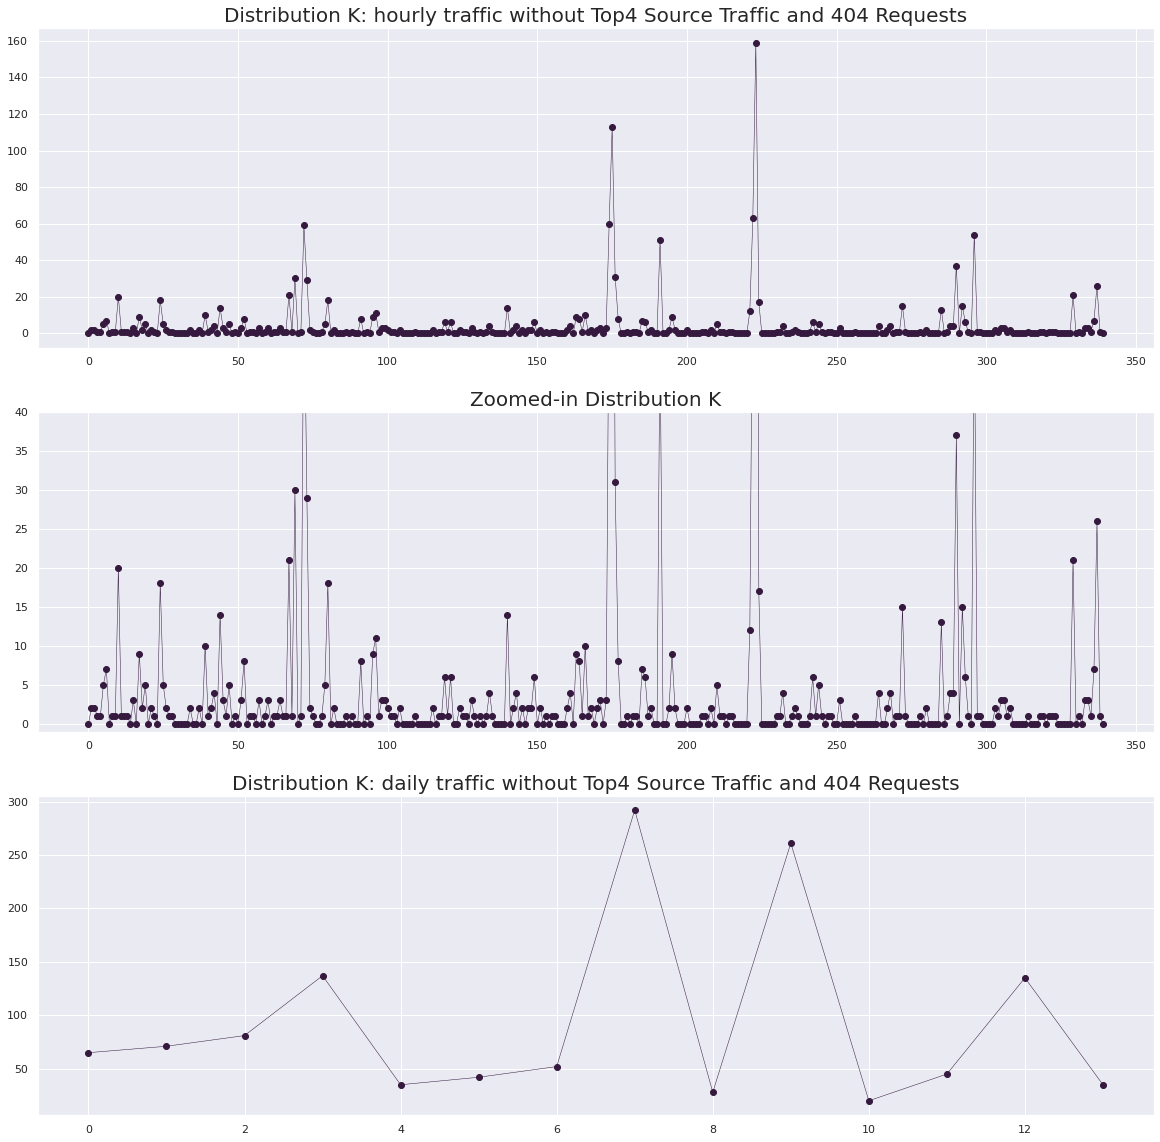

In [ ]:
df_other_than_404_top_4 = df[((df['status_code'] != 404) 
                              & (df['upstream_addr'] != '97.115.172.126') 
                              & (df['upstream_addr'] != '63.143.42.250')
                              & (df['upstream_addr'] != '73.180.17.212'))]

dataset_other, counting_df_other = aggregrate('1H', df_other_than_404_top_4)
fig, axes = plt.subplots(nrows=3, ncols=1)
ax = counting_df_other['request_num'].plot(
    ax=axes[0], linewidth=0.5, marker='o', linestyle='-', color=sns.color_palette("rocket"), figsize=(20,20))
ax_zoomed = counting_df_other['request_num'].plot(
    ax=axes[1], linewidth=0.5, marker='o', linestyle='-', color=sns.color_palette("rocket"), figsize=(20,20))
ax_zoomed = ax_zoomed.set_ylim(-1,40)

dataset_other_by_day, counting_df_other_by_day = aggregrate('1D', df_other_than_404_top_4)
ax_day = counting_df_other_by_day['request_num'].plot(
    ax=axes[2], linewidth=0.5, marker='o', linestyle='-', color=sns.color_palette("rocket"), figsize=(20,20))

axes[0].set_title('Distribution K: hourly traffic without Top4 Source Traffic and 404 Requests', fontsize=20)
axes[1].set_title('Zoomed-in Distribution K', fontsize=20)
axes[2].set_title('Distribution K: daily traffic without Top4 Source Traffic and 404 Requests', fontsize=20)

From the plots, we can observe that under the hourly counting the distribution exhibit 4 peak values at around 75, 175, 225, 290 hours elapsed Nov. 4th 00:00:58; also, under the daily counting the 3, 7, 9, 12 days elapsed Nov.4th have significant more traffic than others. Thus, it is worthwhile inspecting what these datetimes are, and do these datetimes live in our planned downtime? The next section will explore it.

### The Relationship between Planned Downtime and Distribution K

Now we can sort the request number in each one-hour-interval as below shows.

In [ ]:
def sort_count_by_request_num(dataframe, top_n):
    sorted_count_other = dataframe.sort_values(by=['request_num'], ascending=False)[:top_n]
    sorted_count_other['interval_start'] = (sorted_count_other['interval_start']
                                                .dt.tz_localize("GMT")
                                                .dt.tz_convert('America/Los_Angeles')
                                                .dt.tz_localize(None))
    sorted_count_other['interval_end'] = (sorted_count_other['interval_end']
                                              .dt.tz_localize("GMT")
                                              .dt.tz_convert('America/Los_Angeles')
                                              .dt.tz_localize(None))
    return sorted_count_other

sorted_count_other = sort_count_by_request_num(counting_df_other, 20)
sorted_count_other

,interval_start,interval_end,request_num
223,2020-11-12 23:00:58,2020-11-13 00:00:58,159
175,2020-11-10 23:00:58,2020-11-11 00:00:58,113
222,2020-11-12 22:00:58,2020-11-12 23:00:58,63
174,2020-11-10 22:00:58,2020-11-10 23:00:58,60
72,2020-11-06 16:00:58,2020-11-06 17:00:58,59
296,2020-11-16 00:00:58,2020-11-16 01:00:58,54
191,2020-11-11 15:00:58,2020-11-11 16:00:58,51
290,2020-11-15 18:00:58,2020-11-15 19:00:58,37
176,2020-11-11 00:00:58,2020-11-11 01:00:58,31
69,2020-11-06 13:00:58,2020-11-06 14:00:58,30


In the above table which shows the top 20 number of requests in distribution K, the bold number in the leftmost column is the number of hour elapsed Nov 4th 00:00:58. The one-hour-interval of bold number 223, 175, 222, 174, 72 (top 5 in the table) all live in our planned downtime. Also, we can show that top 5 rows contribute 53% traffic to distribution K (see calculation below). 



In [ ]:
sum(sorted_count_other['request_num'][:5]) / sum(sorted_count_other['request_num'][:])

0.5297549591598599

### Exploring the unknown fourth top traffic source -- 73.180.17.212

Recall the distribution of the 4th top traffic source, ip 73.180.17.212, which also exhibit the trend that peak values appear in our downtime. The following figure plots the comparsion between the distribution of 73.180.17.212 and the distribution above.

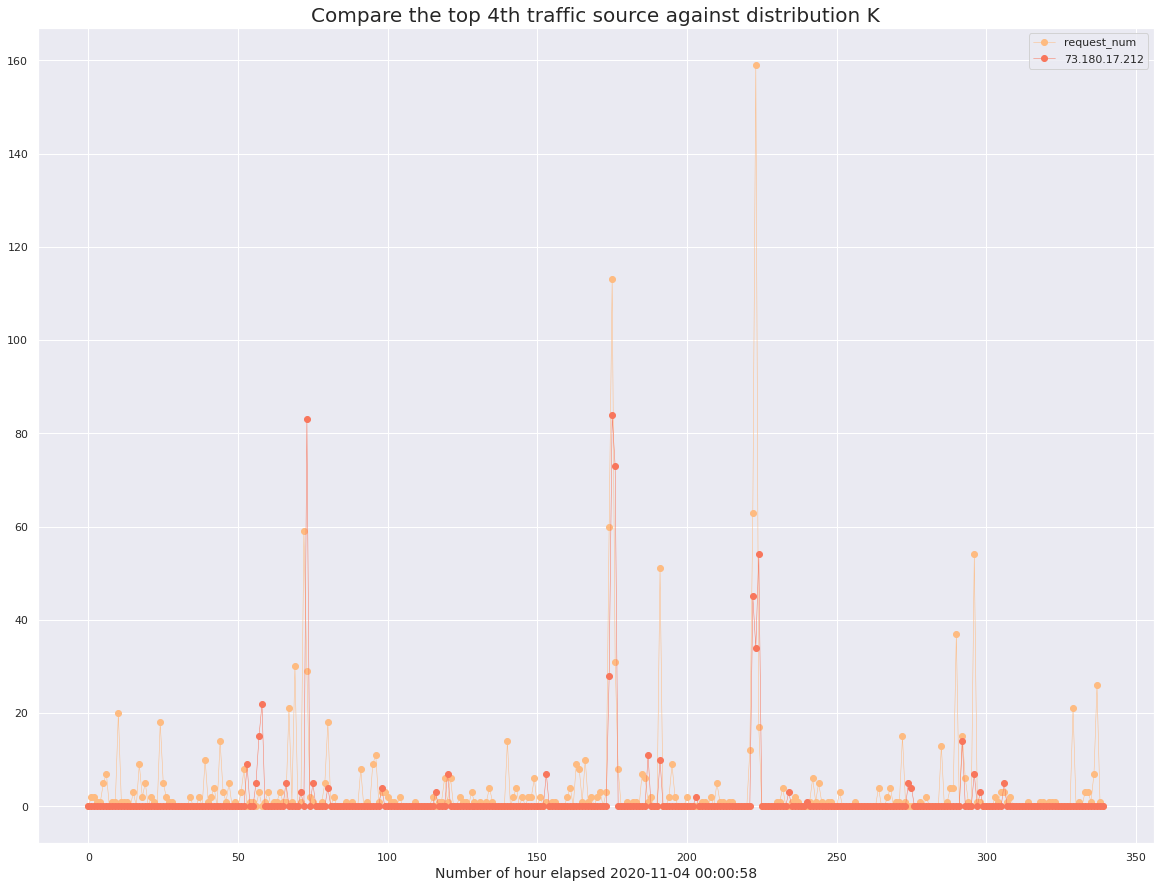

In [ ]:
assembled_4th, ax = assemble_ip_counts_with_overall(counting_df_other, [(ip_4th_count, "73.180.17.212")])
title = ax.set_title("Compare the top 4th traffic source against distribution K", fontsize=20)
xlabel = ax.set_xlabel("Number of hour elapsed {s}".format(s=count_df_hour.iloc[0]['interval_start']), fontsize=14)

Is 73.180.17.212 one of our team member's address? It can't be told too much so far. However, from the above plot, it is obvious that the distribution of 73.180.17.212 fit into some parts of Distribution K. Especially 73.180.17.212's peak value (as shown in the table below, top 9 rows) completely fit in our planned downtime. 

In [ ]:
sorted_count_4th = sort_count_by_request_num(ip_4th_count, 20)
sorted_count_4th

,interval_start,interval_end,request_num
175,2020-11-10 23:00:58,2020-11-11 00:00:58,84
73,2020-11-06 17:00:58,2020-11-06 18:00:58,83
176,2020-11-11 00:00:58,2020-11-11 01:00:58,73
224,2020-11-13 00:00:58,2020-11-13 01:00:58,54
222,2020-11-12 22:00:58,2020-11-12 23:00:58,45
223,2020-11-12 23:00:58,2020-11-13 00:00:58,34
174,2020-11-10 22:00:58,2020-11-10 23:00:58,28
58,2020-11-06 02:00:58,2020-11-06 03:00:58,22
57,2020-11-06 01:00:58,2020-11-06 02:00:58,15
292,2020-11-15 20:00:58,2020-11-15 21:00:58,14


Since 73.180.17.212 has some similarity with Distribution K, also it fits in our planned downtime. Now an idea come up is: how about instead of letting 73.180.17.212 to be a individual distribution used in prediction that is only for 73.180.17.212, we put 73.180.17.212 as part of Distribution K together. 

The following plots the historgam of top 5 traffic source among 73.180.17.212 and source used in Distribution K in each day. 

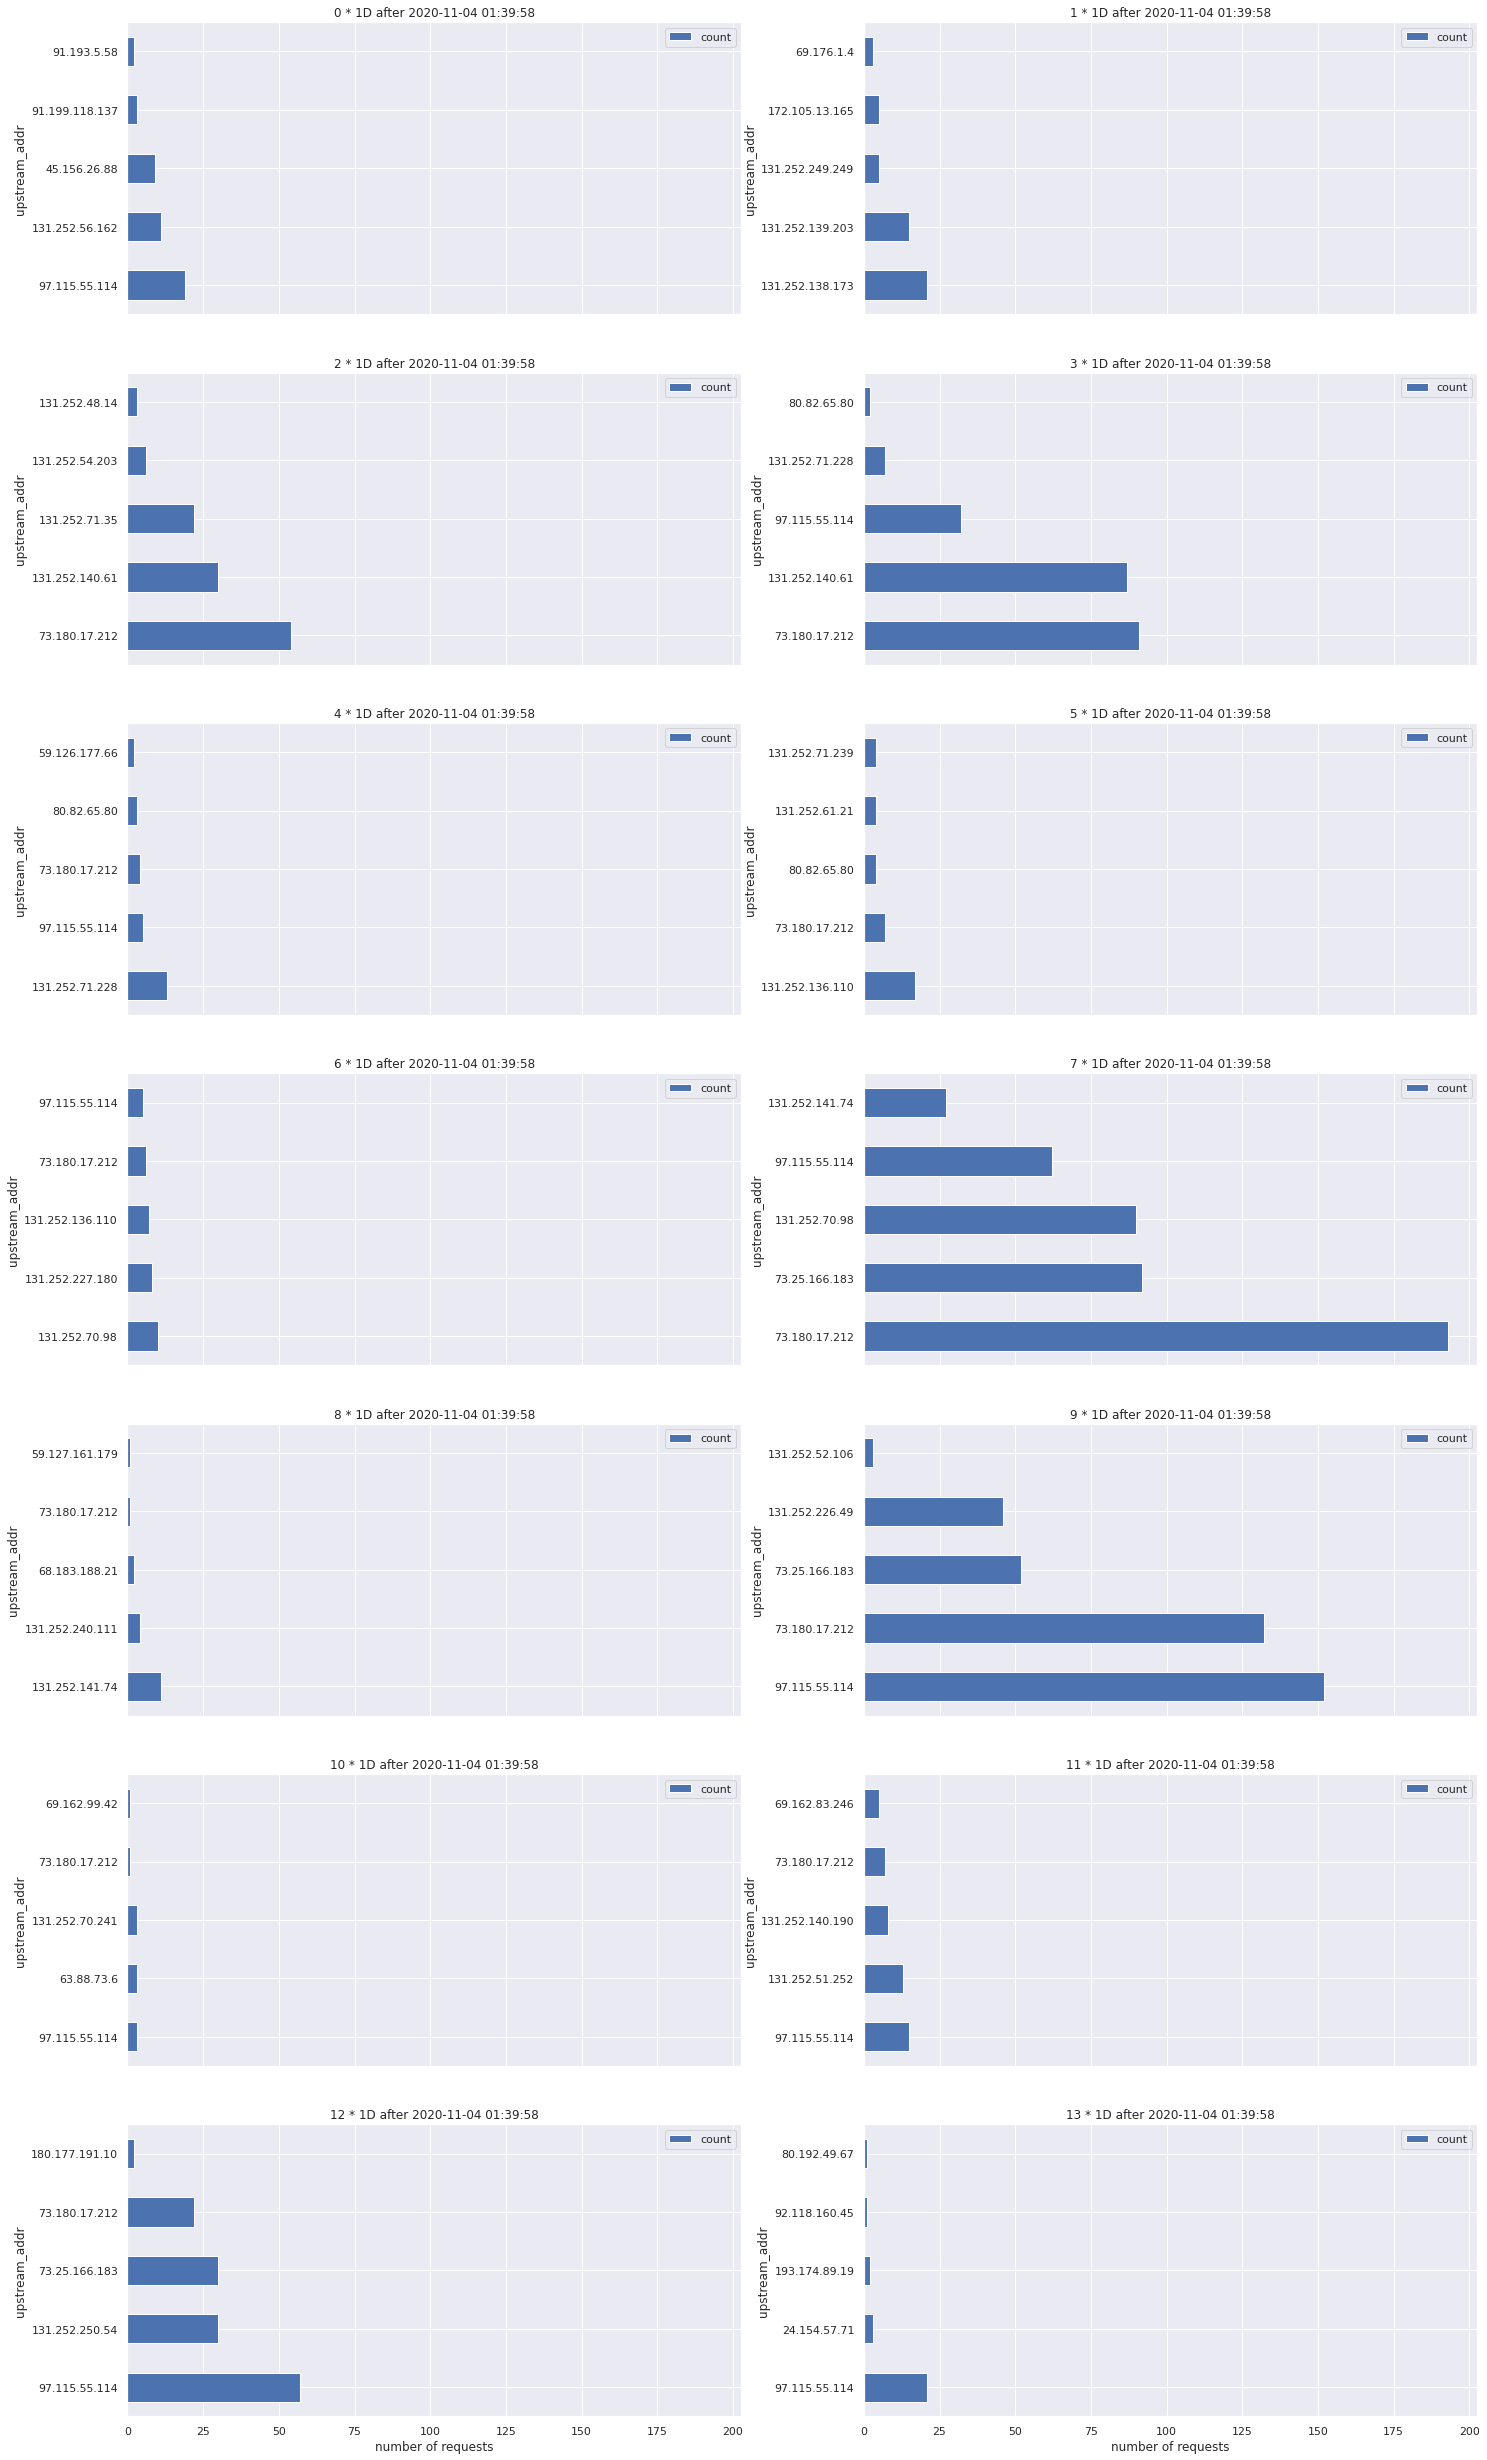

In [ ]:
df_73_180_17_212_and_k = df[((df['status_code'] != 404) 
                           & (df['upstream_addr'] != '97.115.172.126') 
                           & (df['upstream_addr'] != '63.143.42.250'))]

d_73_180_17_212_and_k = Analysis('1D', dataframe=df_73_180_17_212_and_k)
d_73_180_17_212_and_k.plot_top_n(5)

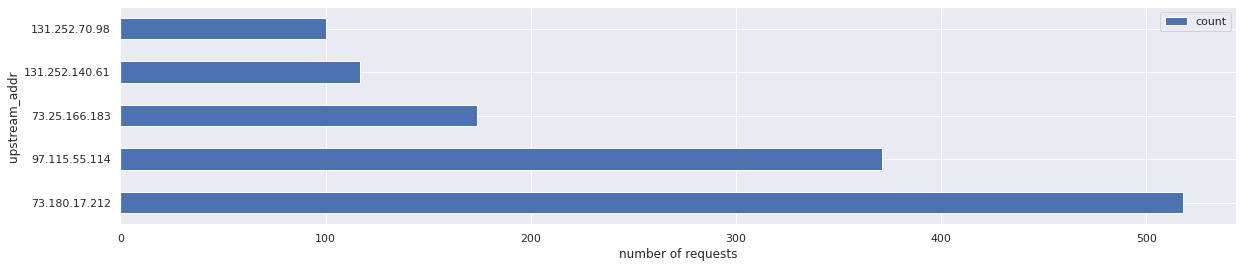

In [ ]:
d1_73_180_17_212_and_k = Analysis('14D', dataframe=df_73_180_17_212_and_k)
d1_73_180_17_212_and_k.plot_top_n(5, single_figsize=(20,4), n_cols=1)

From the above 1-day-basis histograms we can see that in each day that has a down time (in the above figures, 2, 3, 7, and 9 * '1D' after first figure), there are significant traffic than others. The day "12 * '1D'" also has more traffic since it is the due day of assignment 3. In addition, when comparing between 1-day-basis figure with 14-day-basis figure (the figure at the bottom), the ip addresses of top 5 are approximately consisent (especially the day has a downtime). 

**All in all.** As proved above, we assume that the client "73.180.18.212" visit our site is independent with Dist K, thus we can say if C denotes the client 73.180.18.212  then f(C,K)=f(C)f(k). Thus, we can make the hypothesis that **Distribution K** is mainly constituted by our 4 team members' traffic and all other traffic except from Bruce, Uptimebot and 404. 

## Modeling the Traffic and Prediction


### Method of Modeling
Now it's time to start our **prediction**!

The traffic to model will be using an additive model: Toal request = Estimator(Bruce) + Estimator(uptime bot) + Estimator(404) + Estimator(Dist. K). 

First, without doublt we shoud use linear regression on Estimator(uptime bot).

One thing you may notice is that we didn't take the first about 48 hours' data into account because our group didn't finish set up at that time.


Training R^2:  -0.16185230832323194
Coefficients: 
 [0.00110129]
Mean squared error: 0.13
Coefficient of determination: -0.20
Model slope:     0.0011012917466869604
Model intercept: 23.745430276757325


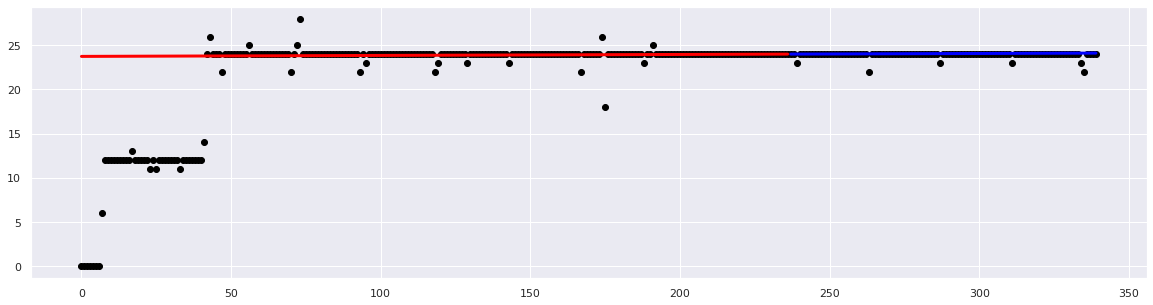

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

class UptimebotRegression:
    
    def __init__(self, training_set_percentage):
        self.training_divider = int(0.7 * len(ip_second_count.index))
        
        # assign these index weight to 0 since our team configure uptime bot in a wrong way
        self.zero_weighted = max(
            ip_second_count.loc[(ip_second_count['request_num'] < 15) & (ip_second_count.index < 50)].index)
        self.mat_weights = np.concatenate((np.zeros(self.zero_weighted), np.ones(self.training_divider - self.zero_weighted)))
        
        self.__construct_dataset()
        self.__regression()
        
        self.test_y_pred = self.reg.predict(self.testing_X)
        self.training_y_pred = self.reg.predict(self.training_X)
        
    def __construct_dataset(self):
        # get training set and testing set
        self.training_X = ip_second_count[:self.training_divider].index.to_numpy().reshape(-1, 1)
        self.training_y = ip_second_count[:self.training_divider]['request_num'].to_numpy()
        self.testing_X  = ip_second_count[self.training_divider:].index.to_numpy().reshape(-1, 1)
        self.testing_y  = ip_second_count[self.training_divider:]['request_num'].to_numpy()
        
    def __regression(self):
        self.reg = LinearRegression().fit(self.training_X, 
                                          self.training_y,
                                          sample_weight=self.mat_weights)
        self.r2  = self.reg.score(self.training_X, self.training_y)
          
    def predict(self, mat_x):
        y_pred = self.reg.predict(mat_x)
        
    def stats(self):
        print('Training R^2: ', self.r2)
        print('Coefficients: \n', self.reg.coef_)
        print('Mean squared error: %.2f' % mean_squared_error(self.testing_y, self.test_y_pred))
        print('Coefficient of determination: %.2f' % r2_score(self.testing_y, self.test_y_pred))

        print("Model slope:    ", self.reg.coef_[0])
        print("Model intercept:", self.reg.intercept_)
    

uptimebot_est = UptimebotRegression(0.7)

uptimebot_est.stats()

sns.set(rc={'figure.figsize':(20, 5)})
plt.scatter(np.concatenate((uptimebot_est.training_X.flatten(), uptimebot_est.testing_X.flatten())), 
            np.concatenate((uptimebot_est.training_y, uptimebot_est.testing_y)),  color='black')
plt.plot(uptimebot_est.testing_X, uptimebot_est.test_y_pred, color='blue', linewidth=3)
plt.plot(uptimebot_est.training_X, uptimebot_est.training_y_pred, color='red', linewidth=3)

### The Most Part of Our Traffic Prediction

Firstly, we attempt to employ a **polynomial regression on Distribution-K**, the following code construct a polynomial regression model. We cumulate the time series data in order to let regressor capture the sudden change in the traffic history. If original data is used (not cumulative), most of the hourly-counted value live near the bottom of x-axis, so the regressor will fit as much of them as possible, the data live far away from the x-axis will be treated as outliars.

Thus, to avoid all the datapoints being treated equally (so the datapoints represent large hour-traffic becomes important), we use a cumulative function.

           7             6            5             4            3
-2.95e-13 x + 4.039e-10 x - 2.17e-07 x + 5.757e-05 x - 0.007807 x
           2
 + 0.5094 x - 9.855 x + 70.05
R_square: 0.99


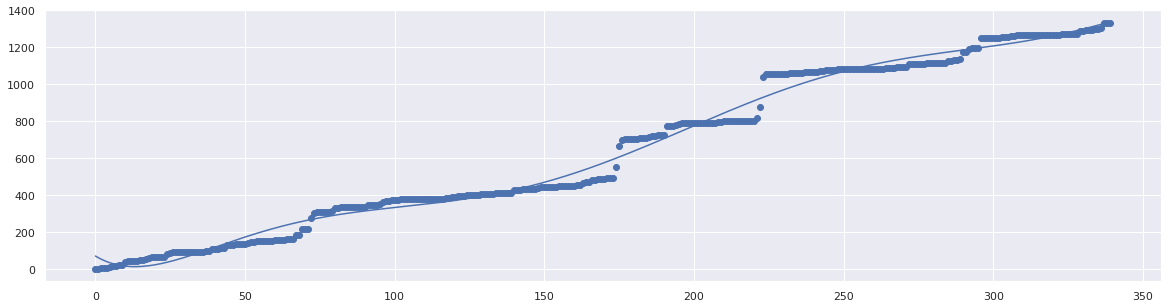

In [ ]:
import pylab
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

dataset = counting_df_other['request_num'].cumsum()
arrY = dataset
arrX = dataset.index.to_numpy()
plt.scatter(arrX,arrY)
fit_y=np.polyval(np.polyfit(arrX,arrY,7),arrX)
plt.plot(arrX,fit_y)
print(np.poly1d(np.polyfit(arrX,arrY,7)))

from sklearn.metrics import r2_score
getmodel=np.poly1d(np.polyfit(arrX,arrY,7))
R_square=r2_score(arrY,getmodel(arrX))
print('R_square: {:.2f}'.format(R_square))  

In [ ]:
class BruceRegression:
    
    def __init__(self, training_set_percentage, poly_deg=3):
        self.dataset = ip_most_count['request_num'].cumsum()
        self.training_divider = int(training_set_percentage * len(ip_most_count.index))
        self.poly_deg = poly_deg
        
        self.__construct_dataset()
        self.__training()
        self.__testing()
        self.r2 = r2_score(self.testing_y, self.pred_y_testing)

    def __training(self):
        self.ps = np.polyfit(self.training_X, self.training_y, self.poly_deg)
        self.pred_y_training = np.polyval(self.ps, self.training_X)   
        
    def __testing(self):
        self.pred_y_testing = np.polyval(self.ps, self.testing_X)

    def __construct_dataset(self):
        # get training set and testing set
        self.training_X = ip_most_count[:self.training_divider].index.to_numpy()
        self.training_y = self.dataset[:self.training_divider]
        self.testing_X  = ip_most_count[self.training_divider:].index.to_numpy()
        self.testing_y  = self.dataset[self.training_divider:]
                                          
    def result_dataframe(self):
        training_df = pd.DataFrame({"degree_{deg}".format(deg=self.poly_deg): self.pred_y_training}, 
                                   index=self.training_X)
        testing_df = pd.DataFrame({"degree_{deg}".format(deg=self.poly_deg): self.pred_y_testing}, 
                                  index=self.testing_X)
        return training_df, testing_df
        
    def peek_dataset(self):
        ax = self.dataset.plot(linewidth=0.5, marker='.', linestyle='-')
        ax.set_title("Cumulative Requests Made by 97.115.172.126 (Bruce)", fontsize=20)
    
    def plot(self):
        sns.set(rc={'figure.figsize':(20, 12)})
        plt.scatter(self.dataset.index.to_numpy(), self.dataset, color='black')                                  
        plt.plot(self.training_X, self.pred_y_training, color='red', linewidth=3)                                  
        plt.plot(self.testing_X, self.pred_y_testing, color='blue', linewidth=3)

In [ ]:
poly_regs = [BruceRegression(0.7, poly_deg=poly_deg) for poly_deg in range(3, 10)]

for i in range(0, len(poly_regs)):
    training_df, testing_df = poly_regs[i].result_dataframe()
    if i == 0:
        result_df = pd.concat([training_df, testing_df])
        result_df['original'] = poly_regs[i].dataset.to_frame()['request_num']
    else:
        result_df = result_df.join(pd.concat([training_df, testing_df]))
        
def plot_bruce_poly_regs(result_df, ylim):     
    sns.set(rc={'figure.figsize':(20, 6)})
    ax = result_df.plot(linewidth=1, color=sns.color_palette("rocket"))
    ax.ticklabel_format(useOffset=False, style='plain')
    plt.ylim(ylim)
    plt.axvline(x=poly_regs[0].training_divider, linestyle='--')
    an = plt.annotate("training/predict divider",
                      xy=(poly_regs[0].training_divider, 0), xytext=(-20, 20),
                      textcoords='offset points', ha='right', va='bottom',
                      bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                      arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    an.arrow_patch.set_color('black')
    return ax

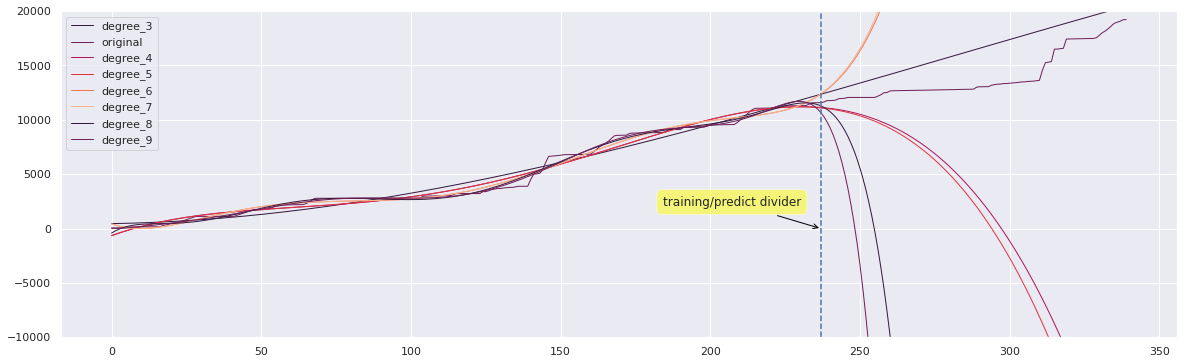

In [ ]:
ax = plot_bruce_poly_regs(result_df, (-10000,20000))

But this model is not suitable for prediction. 

We used 70% data for traning and 30% for testing. The figure above shows the training and testing result of polynomial regression. It shows that the model cannot fit into this problem. We realized that a polynomial function can be curved to fit into training set very well since all the training set is live in a fixed interval. In the training phrase, the regression is totally based on the training set so the cofficients are adjusted to let the regression function fit into traning set. However, if we look outside of the interval that training set live in, the polynoimal function becomes monotone (either increasing or desceasing), thus it cannot used in forecasting (but it can be used in interpolation for missing data). 

Then we tried to employ **moving average and exponential smoothing**, the following code implements the model and shows the predict result.

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

class MovingAverage:
    
    def __init__(self, mv_window=5, row_diff=False, exp_smooth=False, alpha=-1, 
                 external_df=False, provided_dataset=None):
        self.dataset = ip_most_count
        self.row_diff = row_diff
        self.mv_window = mv_window
        self.exp_smooth = exp_smooth
        self.alpha = alpha
        if external_df:
            self.dataset = provided_dataset
        if self.row_diff:
            self.dataset = ip_most_count['request_num'].diff().to_frame()
            self.dataset.iloc[0] = 0
        
        if not exp_smooth:
            self.ma = self.dataset['request_num'].rolling(self.mv_window).mean()
        else:
            self.ma = self.dataset['request_num'].ewm(alpha=self.alpha).mean()
    
        self.stats()

    def plot(self):        
        if self.row_diff:
            plt.plot(self.dataset.index, self.dataset, color='orange')
        else:
            plt.plot(self.dataset.index, self.dataset['request_num'], color='orange')
        if self.exp_smooth:
            plt.plot(self.dataset.index, 
                     self.ma, linewidth=0.5, marker='.',color='blue')
        else:
            plt.plot(self.dataset.index[self.mv_window - 1:], 
                     self.ma[self.mv_window - 1:], linewidth=0.5, marker='.',color='blue')
        plt.legend(["original", "moving average"])
        
    def stats(self):
        predicted = self.ma[self.mv_window - 1:].array
        target = self.dataset[self.mv_window - 1:]['request_num']
        self.mse = mean_squared_error(target, predicted)
        self.r2 = r2_score(target, predicted)
    
    def predict(self, start_at, length):
        history = self.dataset['request_num'][:start_at]
        fit = SimpleExpSmoothing(history).fit()
        fcast = fit.forecast(length)
        if self.row_diff:
            plt.plot(self.dataset.index, self.dataset, color='orange')
        else:
            plt.plot(self.dataset.index, self.dataset['request_num'], color='orange')
        plt.plot(fit.fittedvalues, color='blue', marker='.')
        plt.plot(fcast, color='tomato', marker='.')
        plt.legend(['original', 'fitted', 'predicted'])
        return fcast, fit

In [ ]:
class ExperimentMv:
    
    def __init__(self, window_rng=(2,20), row_diff=False, exp_smooth=False, alpha=-1):
        self.window_rng = window_rng
        self.row_diff = row_diff
        self.alpha = alpha
        self.exp_smooth = exp_smooth
        
        self.__create_models()
        
        window_rng_start = window_rng[0]
        suf = self.get_suffix(0)
        self.combined_result = (self.models[0]
                                    .ma.to_frame()
                                    .add_suffix(suf))
        self.stats = {
            suf: [self.models[0].mse, self.models[0].r2]
        }
        
        for i in range(1, len(self.models)):
            suf = self.get_suffix(i)
            self.combined_result = (self.combined_result.join(
                self.models[i].ma.to_frame().add_suffix(suf)))
            self.stats[suf] = [self.models[i].mse, self.models[i].r2]
    
    def get_suffix(self, index):
        if self.exp_smooth:
            return '_alpha_{suf}'.format(suf=self.alpha[index])
        return '_window_{suf}'.format(suf=self.window_rng[0] + index)
    
    def get_column_name(self, window_sz=0, alpha=0):
        if self.exp_smooth:
            return "request_num_window_{n}".format(n=window_sz)
        else:
            return "request_num_alpha_{alpha}".format(alpha=alpha)
            
    def __create_models(self):
        if not self.exp_smooth:
            self.models = [
                MovingAverage(mv_window=i, 
                              row_diff=self.row_diff) for i in range(self.window_rng[0], 
                                                                     self.window_rng[1])]
        else:
            self.models = [MovingAverage(row_diff=self.row_diff, 
                                         exp_smooth=True,
                                         alpha=alpha) for alpha in self.alpha]
    
    def plot(self, zoom_in=(-1,100)):
        sns.set(rc={'figure.figsize':(20, 20)})
        fig, axes = plt.subplots(nrows=2, ncols=1)
        ax = self.combined_result.plot(ax=axes[0], linewidth=1, marker='.', color=sns.color_palette("rocket"))
        
        ax_zoomed = self.combined_result.plot(ax=axes[1], linewidth=0.5, marker='.', color=sns.color_palette("rocket"))
        ax_zoomed = ax_zoomed.set_ylim(zoom_in)
        

In [ ]:
mv_e1 = ExperimentMv((2,20))
mv_e2 = ExperimentMv((2,20), row_diff=True)

exp_alphas = np.arange(0.01, 1, 0.025)

mv_e3 = ExperimentMv(row_diff=False, exp_smooth=True, alpha=exp_alphas)    
mv_e4 = ExperimentMv(row_diff=True, exp_smooth=True, alpha=exp_alphas)

es, exp_es = [mv_e1, mv_e2], [mv_e3, mv_e4]

mses = [[e.stats['_window_{sz}'.format(sz=i)][0] for i in range(2,20)] for e in es]
r2s = [[e.stats['_window_{sz}'.format(sz=i)][1] for i in range(2,20)] for e in es]

mses_exp = [[e.stats['_alpha_{a}'.format(a=a)][0] for a in exp_alphas] for e in exp_es]
r2s_exp = [[e.stats['_alpha_{a}'.format(a=a)][1] for a in exp_alphas] for e in exp_es]  
    

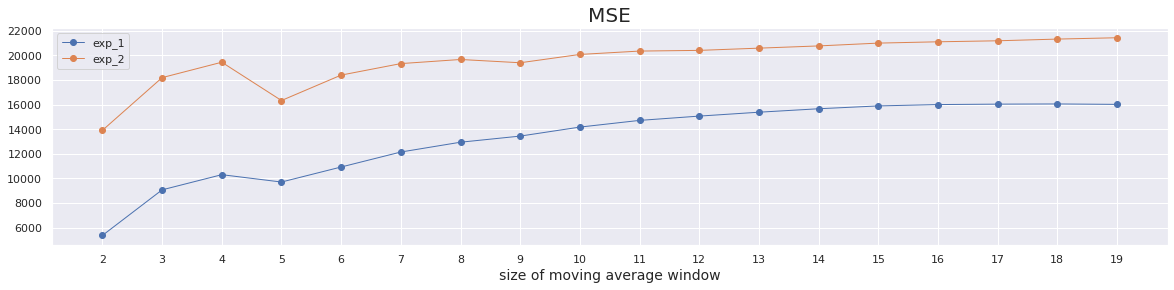

In [ ]:
def plot_mv_exps(stats, title):
    sns.set(rc={'figure.figsize':(20, 4)})
    for stat in stats:
        ax = plt.plot(list(range(2,20)), stat, linewidth=1, marker='o')
    ax = plt.legend(['exp_{i}'.format(i=i) for i in range(1,3)])
    ax = plt.xticks(np.arange(2,20))
    ax = plt.xlabel("size of moving average window", fontsize=14)
    ax = plt.title(title, fontsize=20)
    
plot_mv_exps(mses, "MSE")

**MSE** (mean/average squared error)=[sum(target-pred)^2]/n

**R^2** (R square) shows how the data fits into the model. Close to 1, relevant. Close to 0, irrelevant.


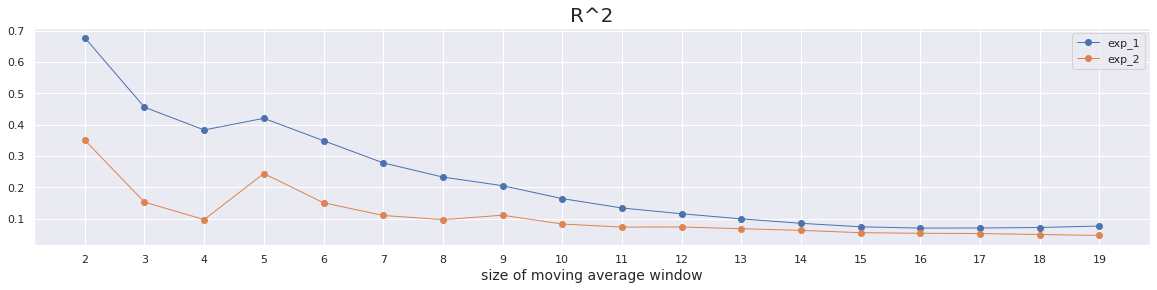

In [ ]:
plot_mv_exps(r2s, "R^2")

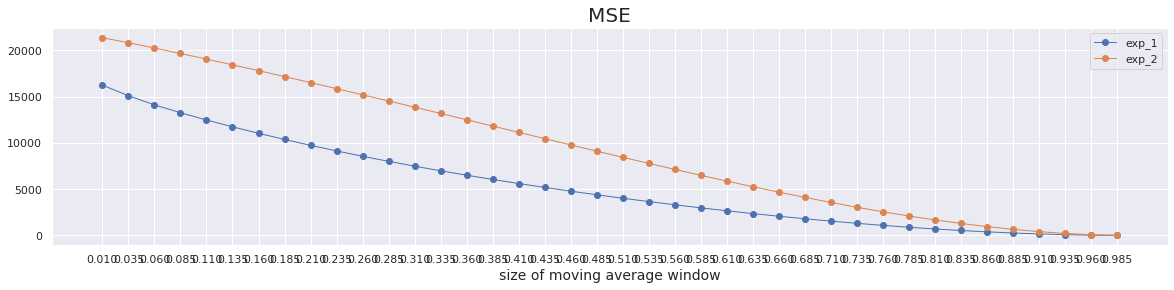

In [ ]:
def plot_exponential_smoothing_exps(stats, title):
    sns.set(rc={'figure.figsize':(20, 4)})
    for stat in stats:
        ax = plt.plot(exp_alphas, stat, linewidth=1, marker='o')
    ax = plt.legend(['exp_{i}'.format(i=i) for i in range(1,3)])
    ax = plt.xticks(exp_alphas)
    ax = plt.xlabel("size of moving average window", fontsize=14)
    ax = plt.title(title, fontsize=20)

plot_exponential_smoothing_exps(mses_exp, "MSE")

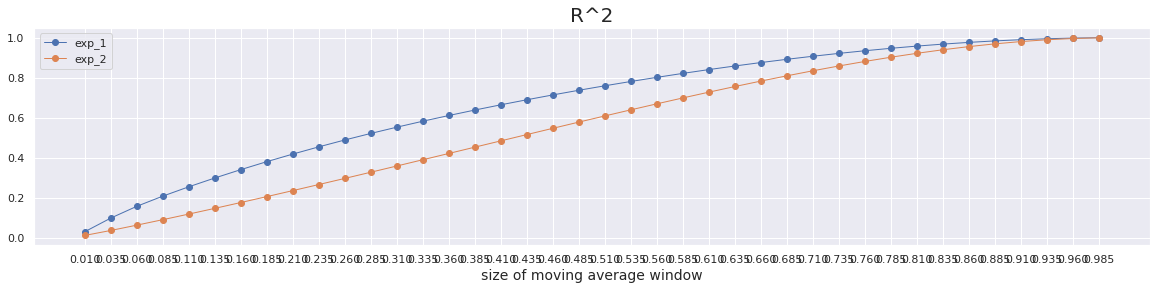

In [ ]:
plot_exponential_smoothing_exps(r2s_exp, "R^2")

**Moving average with exponential smoothing** effectively capture the trend under the data, but in the prediction the predicted data is quickly averaged to be constant. At least this model is better than polynomial regression. (lol)

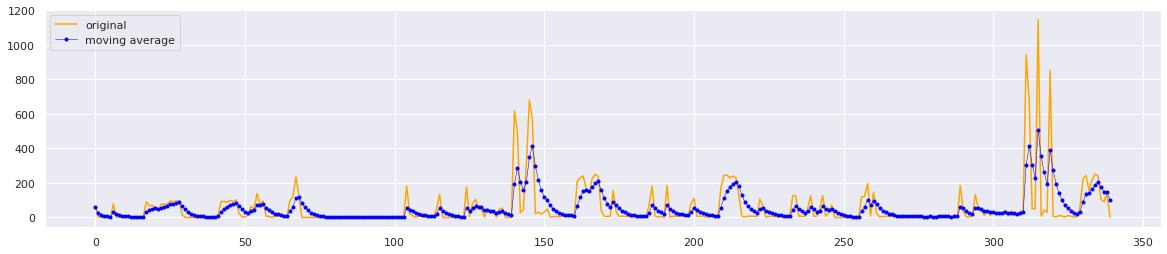

In [ ]:
bruce_predictor = MovingAverage(alpha=0.3, exp_smooth=True)
bruce_predictor.plot()

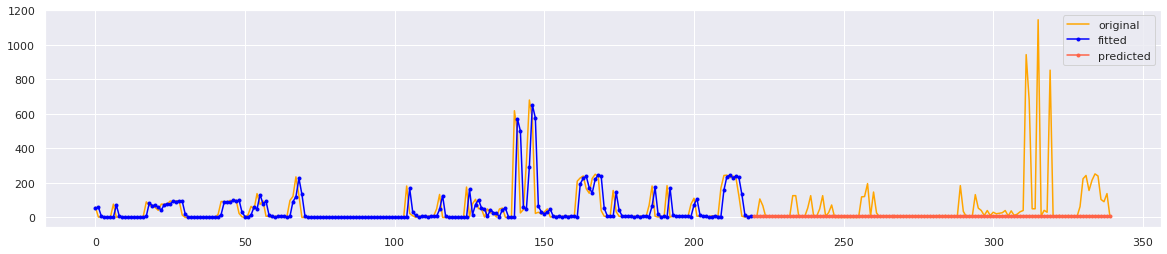

In [ ]:
fcast, fit1 = bruce_predictor.predict(220, 120)

Finally we tried to use **seasonal decomposition** to capture trand, periodic property under each distribution, in the same time remove some noise.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

class Decomposition:

    def __init__(self, dataset):
        self.dataset = pd.Series(data=dataset['request_num'].to_numpy(), index=dataset['interval_start'])
        self.comps = seasonal_decompose(self.dataset)
        
        sns.set(rc={'figure.figsize':(20, 16)})
        
        fig, axes = plt.subplots(nrows=4, ncols=1)
        
        ax1 = self.comps.observed.plot(ax=axes[0], marker='.')
        ax1.set_title("observation", loc='right', fontsize=20)
        
        ax2 = self.comps.seasonal.plot(ax=axes[1])
        ax2.set_title("seasonality", loc='right', fontsize=20)
        
        ax3 = self.comps.trend.plot(ax=axes[2])
        ax3.set_title("trend", loc='right', fontsize=20)
        
        ax4 = self.comps.resid.plot(ax=axes[3])
        ax4.set_title("residual", loc='right', fontsize=20)
        
    def export_dataframe(self):
        ob = self.comps.observed.to_frame(name='request_num').reset_index()
        sea = self.comps.seasonal.to_frame(name='request_num').reset_index()
        tre = self.comps.trend.to_frame(name='request_num').reset_index()
        resid = self.comps.resid.to_frame(name='request_num').reset_index()
        return ob, sea, tre, resid

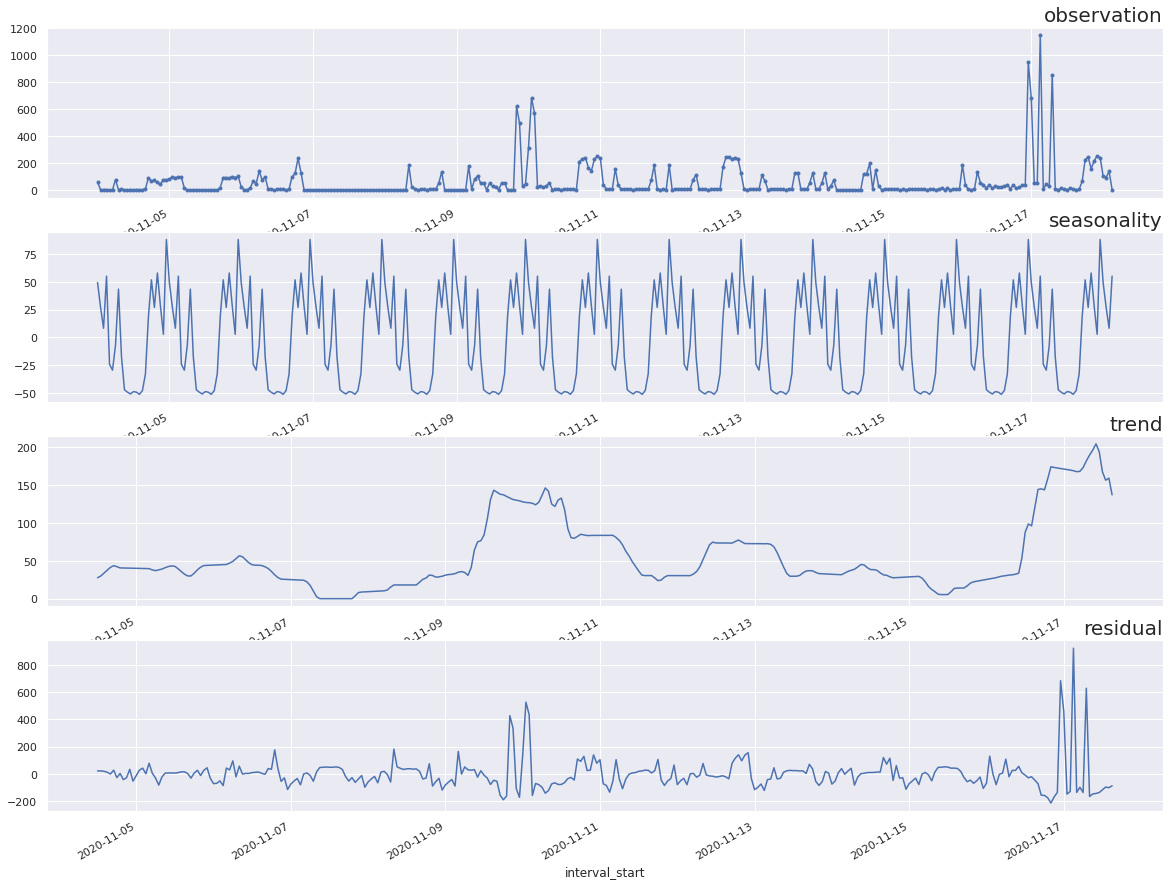

In [ ]:
bruce_decomp = Decomposition(ip_most_count)
ob, sea, tre, resid = bruce_decomp.export_dataframe()



After decompositon, we observed that the distrubtion exhibited a strong periodic property, the trend also seems to be periodic when the function is divided on Nov. 11th. **Thus, we decided to use seasonality + trend to predict next 14 days distribution.**

### The Prediction of Bruce requests

Text(0.5, 0, 'number of hour after Nov.18th 00:00:58')

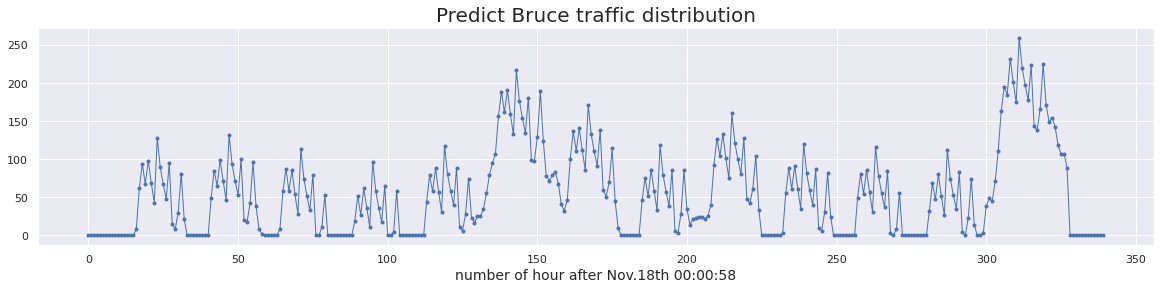

In [ ]:
pred = np.add(sea['request_num'].to_numpy(), tre['request_num'].to_numpy())
pred = np.nan_to_num(pred.clip(min=0))
sns.set(rc={'figure.figsize':(20, 4)})
ax = plt.plot(np.arange(len(pred)), pred, linewidth=1, marker='.')
plt.title('Predict Bruce traffic distribution', fontsize=20)
plt.xlabel("number of hour after Nov.18th 00:00:58", fontsize=14)

### The Prediction of Distribution K

After decomponsition, we observed that the trend completely fited out downtime. Thus, we decided to use the same way as Bruce's traffic prediction.

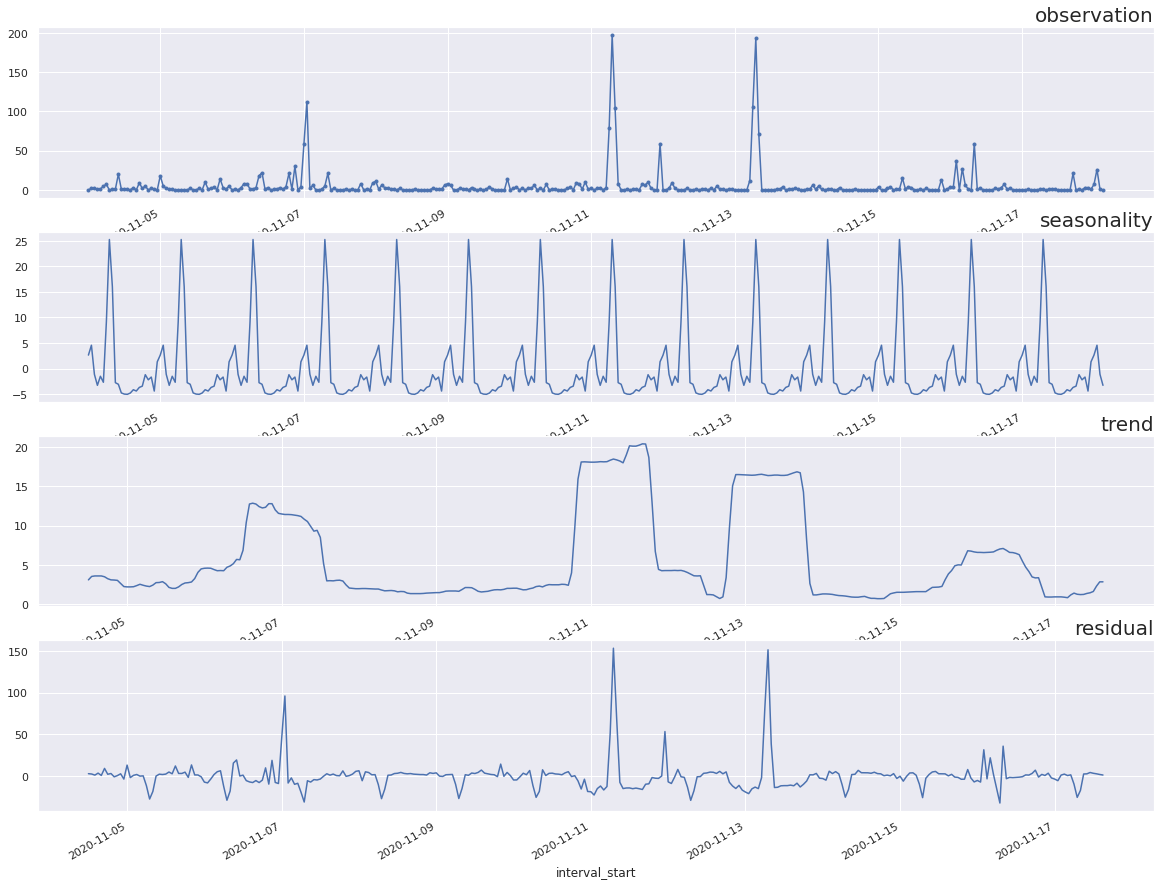

In [ ]:
df_k = df[((df['status_code'] != 404) 
         & (df['upstream_addr'] != '97.115.172.126') 
         & (df['upstream_addr'] != '63.143.42.250'))]

d_k = Analysis('1H', dataframe=df_k).count_df

k_dist_decomp = Decomposition(d_k)
ob1, sea1, tre1, resid1 = k_dist_decomp.export_dataframe()

Text(0.5, 0, 'number of hour after Nov.18th 00:00:58')

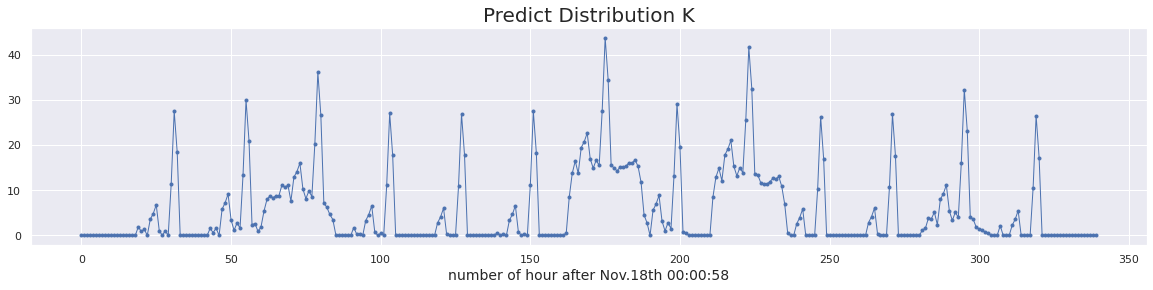

In [ ]:
pred1 = np.add(sea1['request_num'].to_numpy(), tre1['request_num'].to_numpy())
pred1 = np.nan_to_num(pred1.clip(min=0))
sns.set(rc={'figure.figsize':(20, 4)})
ax = plt.plot(np.arange(len(pred1)), pred1, linewidth=1, marker='.')
plt.title('Predict Distribution K', fontsize=20)
plt.xlabel("number of hour after Nov.18th 00:00:58", fontsize=14)

### The Prediction of 404 traffic

For 404 Distribution, most of the so-called "script clients" (who write script to explore sites) only visit once of our site, thus seaconality + trend also capture such characteristic. Also, two special cases (explosive 404 errors) are categoried into residual, which is conisitent with intuition that it could be noise.  

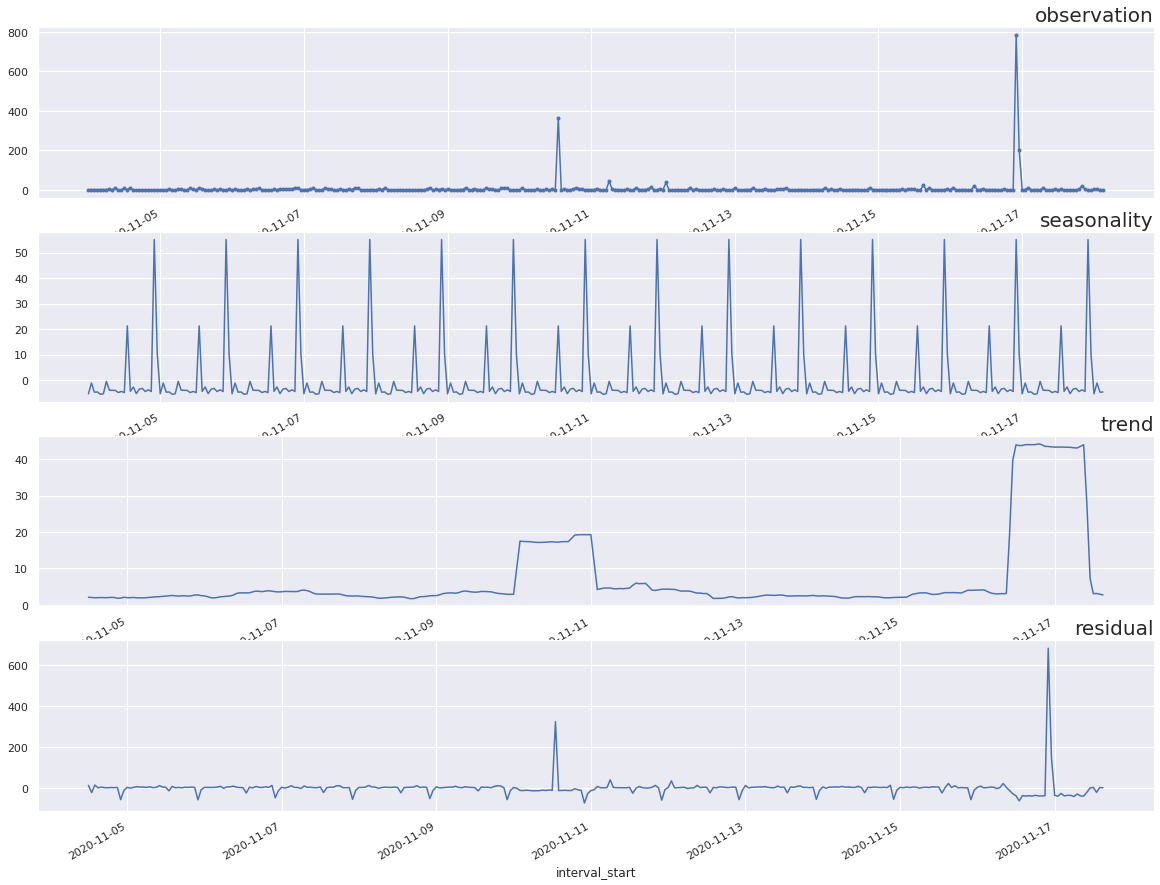

In [ ]:
dist_404_decomp = Decomposition(counting_df_404)
ob2, sea2, tre2, resid2 = dist_404_decomp.export_dataframe()

Text(0.5, 0, 'number of hour after Nov.18th 00:00:58')

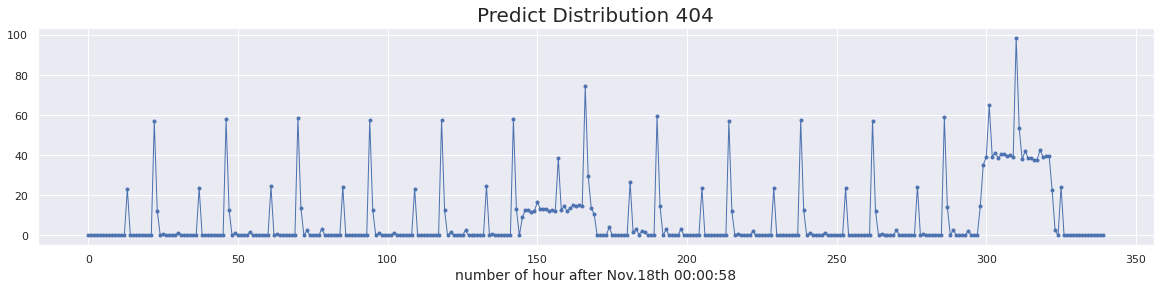

In [ ]:
pred2 = np.add(sea2['request_num'].to_numpy(), tre2['request_num'].to_numpy())
pred2 = np.nan_to_num(pred2.clip(min=0))
sns.set(rc={'figure.figsize':(20, 4)})
ax = plt.plot(np.arange(len(pred2)), pred2, linewidth=1, marker='.')
plt.title('Predict Distribution 404', fontsize=20)
plt.xlabel("number of hour after Nov.18th 00:00:58", fontsize=14)

## Conclusion

Text(0.5, 0, 'number of hour after Nov.18th 00:00:58')

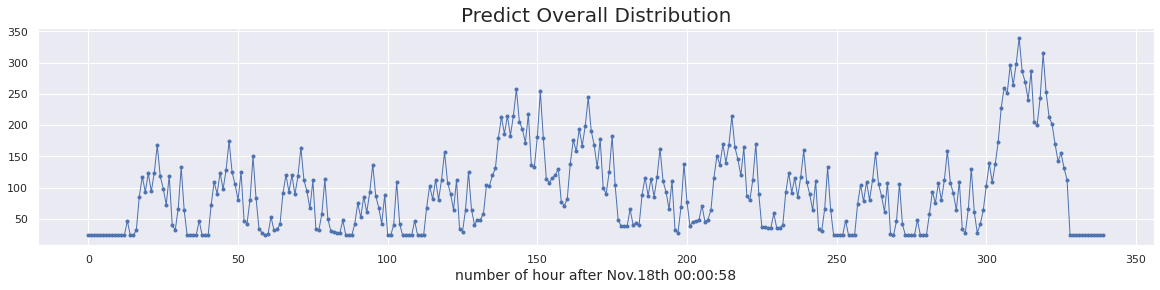

In [ ]:
overall = np.add(pred, pred1)
overall = np.add(overall, pred2)
overall = np.add(overall, np.full(len(pred), 24))

sns.set(rc={'figure.figsize':(20, 4)})
ax = plt.plot(np.arange(len(overall)), overall, linewidth=1, marker='.')
plt.title('Predict Overall Distribution', fontsize=20)
plt.xlabel("number of hour after Nov.18th 00:00:58", fontsize=14)

Notice that Seaonality + Trend + Residual = Observation, only use seasonlity + trend cannot make a big difference with copy last 14 days distribution (since we only remove the noise). Thus, we perfrom an exponential smoothing on the predicted overall distribution to emphasis on the underlying pattern instead of its exact shape.

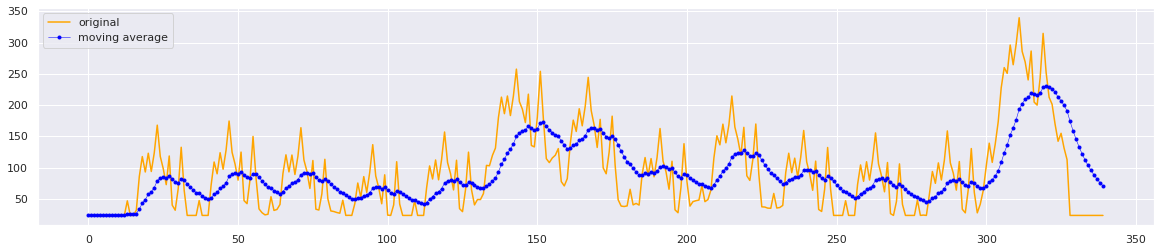

In [ ]:
# sorry, this code is ugly (should be refactored into aggregrate())
start, end = df.index[0], df.index[-1]
rng = pd.date_range(start, end, freq='1H', closed='left')
overall_df = pd.DataFrame(zip([rng[i] for i in range(0, len(rng) - 1)],
                              [rng[i] for i in range(1, len(rng))],
                              [d for d in overall]), 
                           columns=['interval_start', 'interval_end', 'request_num'])

to_smooth = MovingAverage(alpha=0.1, external_df=True,provided_dataset=overall_df, exp_smooth=True)
to_smooth.plot()
overall = to_smooth.ma.to_numpy()

In [ ]:
predict_by_day = []
for i in range(0, 14):
    if i == 0:
        predict_by_day.append(overall[0:23])
    else:
        predict_by_day.append(overall[i * 24:(i + 1) * 24])

[1386.818342995376, 2133.279048116201, 3675.548657510222, 2929.7115788464494, 2096.3435952829677, 2429.9679578401856, 1772.1043825738677]


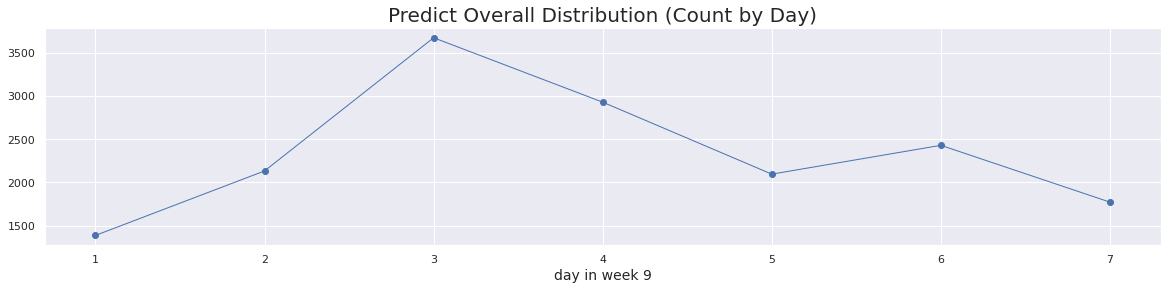

In [ ]:
p = [sum(c) for c in predict_by_day[4:11]]
plt.plot(np.arange(1,8), p, linewidth=1, marker='o')
plt.title('Predict Overall Distribution (Count by Day)', fontsize=20)
plt.xlabel("day in week 9", fontsize=14)
print(p)